# IMPORTING LIBRARIES

In [1]:
import os
import panel as pn
from kinopy.io import read_record
from kinopy.viz.biosignal import plot_signal
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import signal
from scipy.ndimage import uniform_filter1d
from scipy.signal import find_peaks, firwin, kaiserord, lfilter, butter, filtfilt, detrend
import numpy as np
from sklearn.datasets import load_digits
from sklearn.decomposition import FastICA
from pylab import figure, clf, plot, xlabel, ylabel, xlim, ylim, title, grid, axes, show, legend, axis
from scipy.signal import lfilter, medfilt, resample, kaiserord, firwin, freqz, correlate
from math import pi
from numpy import array, matrix, multiply, arange, absolute
from kinopy.commons.types import Number
from typing import Sequence, Optional, Literal, Tuple
import scipy.stats as st
from collections.abc import Iterable
from psd2 import psd2
from sklearn.metrics import mean_absolute_error
import neurokit2 as nk

# DATA LOADING

In [2]:
main_path = "/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/"
path_all = []
for i in sorted(os.listdir(main_path)):
    sub_path = os.path.join(main_path, i)
    sub = sorted(os.listdir(sub_path))
    for k in sub:
        subsub_path = os.path.join(sub_path, k)
        subsub = sorted(os.listdir(subsub_path))
        if len(subsub) == 2:
            path_all.append((os.path.join(subsub_path, str(subsub[0]))))
            path_all.append((os.path.join(subsub_path, str(subsub[1]))))
        else:
            path_all.append((os.path.join(subsub_path, str(subsub[0]))))
            
path_all

['/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/Sub-A/BDC10/K-ICB_A_BDC10_20190330-101553_gwoB4aykkTA8fy',
 '/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/Sub-A/BDC9/K-ICB_A_BDC9_20190331-111511_BKe5wNpmMCVETk',
 '/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/Sub-A/BDC9/K-ICB_A_BDC9_20190331-112912_BKe5wrlWOhVETk',
 '/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/Sub-A/FAM/K-ICB_A_FAM_20190330-100233_vk0azV9DkUKXi4',
 '/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/Sub-A/HDT21/K-ICB_A_HDT21_20190429-110822_gwoxGB2nzSA8fy',
 '/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/Sub-A/HDT5/K-ICB_A_HDT5_20190413-090257_BKe0M07rPhVETk',
 '/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/Sub-A/HDT56/K-ICB_A_HDT56_20190603-110736_gwokQXN5vFA8fy',
 '/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/Sub-A/R1/K-ICB_A_R1_20190609-131324_bB5V5zalQtYqid',
 '/home/giuseppeditursi/Documents/Data/K-ICB/raw_v2/Sub-A/R1/K-ICB_A_R1_20190609-132625_bB5V5pwQQSYqid',
 '/home/giuseppeditursi

In [3]:
measurement = path_all[1]
record = read_record(measurement)
record

<Record 'K-ICB_A_BDC9_20190331-111511_BKe5wNpmMCVETk' (signals: 3, segmentations: 0, metrics: 0)>
Meta Data:
    id                      K-ICB_A_BDC9_20190331-111511_BKe5wNpmMCVETk
    code                    BDC9
    date                    2019-03-31T11:15:11+00:00
    subject                 A | Male | 1.8m | 72.8kg
    phone                   iPhone | iOS N/A | sw:2018.0.3.2
    device                  1.06 | hw:2017.0 | fw:2018.0.4.0
Signals:
    'ecg'                   electric/ecg        (451.06s, 200Hz)
    'scg'                   mechanical/scg      (451.06s, 200Hz)
    'bcg'                   mechanical/bcg      (451.06s, 200Hz)

In [4]:
fs = 200

In [5]:
scg = record.signals["scg"]
scg

<Biosignal 'scg' mechanical/scg (451.06s, 200Hz)>
Subsignals:  dis, vel, acc
Dimensions:  (motion: 2, time: 90212, axis: 3)

In [6]:
# Lin
s_lin = scg.vel.sel(motion="lin").values    

# Rot
s_rot = scg.vel.sel(motion="rot").values

# DATA PROCESSING

## RESPIRATION EXTRACTION

In [8]:
time_frame = [10.806, 50.806]

### Fast ICA

In [7]:
def fast_ica(arr: np.ndarray, n_components: int, max_iter: int = 1000) -> np.ndarray:
    """
    Fast Independent Component Analysis on array.

    Parameters
    ----------
    arr : array_like
        The array on which the Fast ICA is applied
    n_components : int, optional
        The number of components seeked by the Fast ICA
    max_iter : int, optional
        Maximum number of iterations during fitting

    Returns
    -------
    result : ndarray
        Shape (len(arr), n_components)
    """
    ica = FastICA(n_components=n_components, max_iter=max_iter)
    return ica.fit_transform(arr)

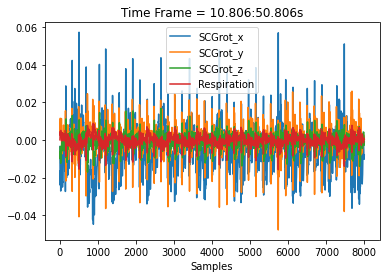

In [9]:
resp = fast_ica(s_rot, n_components=1)[:, 0]
srot_cut = s_rot[int(time_frame[0]*fs):int(time_frame[1]*fs)]
plt.plot(srot_cut)
resp_cut = resp[int(time_frame[0]*fs):int(time_frame[1]*fs)]
plt.plot(resp_cut)
plt.xlabel('Samples')
plt.title('Time Frame = ' +str(time_frame[0])+ ':' +str(time_frame[1])+ 's')
plt.legend(['SCGrot_x', 'SCGrot_y', 'SCGrot_z', 'Respiration'])

### Filtering

In [10]:
def _fir_taps_fred_harris(
    fs: int, fpass: Number, fstop: Number, attenuation: int
) -> int:
    """
    Fred-Harris rule of thumb.
    N_taps = [fs / (fstop - fpass)] * [Atten(dB) / 22]

    Example:
        fs = 200 Hz
        fpass = 30 Hz
        fstop = 33 Hz
        df = fstop - fpass = 3 Hz
        Atten = 60 dB
        => N_taps = 182

    Parameters
    ----------
    fs : int
        The sampling frequency
    fpass : int
        The pass frequency of the transition band
    fstop : int
        The stop frequency of the transition band
    attenuation : int
        The desired attenuation (dB)
    """
    return int((fs / (fstop - fpass)) * (attenuation / 22))

def filt_fir(
    sig: np.ndarray,
    fs: int,
    fcutoff: Sequence[Number],
    filt_type: Literal["lowpass", "highpass", "bandpass", "bandstop"],
    n_taps: Optional[int] = None,
    axis: int = 0,
) -> np.ndarray:
    if n_taps is None:
        n_taps = _fir_taps_fred_harris(fs, fcutoff[-1], fcutoff[-1] + 3, 60)
    if n_taps % 2 == 0:
        n_taps += 1
    a = np.array([1])
    b = firwin(numtaps=n_taps, cutoff=fcutoff, fs=fs, pass_zero=filt_type)
    return filtfilt(b, a, sig, axis=axis)

Text(0.5, 1.0, 'RESPIRATION - Time Frame = 10.806:50.806s')

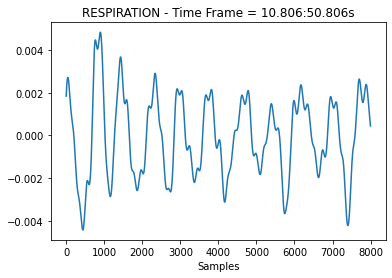

In [11]:
fcutoff = [0.1, 1]
resp = filt_fir(resp, fs, fcutoff=fcutoff, filt_type="bandpass")
resp_cut = resp[int(time_frame[0]*fs):int(time_frame[1]*fs)]
plt.plot(resp_cut)
plt.xlabel('Samples')
plt.title('RESPIRATION - Time Frame = ' +str(time_frame[0])+ ':' +str(time_frame[1])+ 's')

In [12]:
def _normalize_sequence(input, rank):
    """If input is a scalar, create a sequence of length equal to the
    rank by duplicating the input. If input is a sequence,
    check if its length is equal to the length of array.
    """
    is_str = isinstance(input, str)
    if not is_str and isinstance(input, Iterable):
        normalized = list(input)
        if len(normalized) != rank:
            err = "sequence argument must have length equal to input rank"
            raise RuntimeError(err)
    else:
        normalized = [input] * rank
    return normalized

def _get_output(output, input, shape=None, complex_output=False):
    if shape is None:
        shape = input.shape
    if output is None:
        if not complex_output:
            output = np.zeros(shape, dtype=input.dtype.name)
        else:
            complex_type = np.promote_types(input.dtype, np.complex64)
            output = np.zeros(shape, dtype=complex_type)
    elif isinstance(output, (type, np.dtype)):
        # Classes (like `np.float32`) and dtypes are interpreted as dtype
        if complex_output and np.dtype(output).kind != 'c':
            warnings.warn("promoting specified output dtype to complex")
            output = np.promote_types(output, np.complex64)
        output = np.zeros(shape, dtype=output)
    elif isinstance(output, str):
        output = np.sctypeDict[output]
        if complex_output and np.dtype(output).kind != 'c':
            raise RuntimeError("output must have complex dtype")
        output = np.zeros(shape, dtype=output)
    elif output.shape != shape:
        raise RuntimeError("output shape not correct")
    elif complex_output and output.dtype.kind != 'c':
        raise RuntimeError("output must have complex dtype")
    return output

def uniform_filter(input, size=3, output=None, mode="reflect",
                   cval=0.0, origin=0):
    """Multidimensional uniform filter.

    Parameters
    ----------
    %(input)s
    size : int or sequence of ints, optional
        The sizes of the uniform filter are given for each axis as a
        sequence, or as a single number, in which case the size is
        equal for all axes.
    %(output)s
    %(mode_multiple)s
    %(cval)s
    %(origin_multiple)s

    Returns
    -------
    uniform_filter : ndarray
        Filtered array. Has the same shape as `input`.

    Notes
    -----
    The multidimensional filter is implemented as a sequence of
    1-D uniform filters. The intermediate arrays are stored
    in the same data type as the output. Therefore, for output types
    with a limited precision, the results may be imprecise because
    intermediate results may be stored with insufficient precision.

    Examples
    --------
    >>> from scipy import ndimage, misc
    >>> import matplotlib.pyplot as plt
    >>> fig = plt.figure()
    >>> plt.gray()  # show the filtered result in grayscale
    >>> ax1 = fig.add_subplot(121)  # left side
    >>> ax2 = fig.add_subplot(122)  # right side
    >>> ascent = misc.ascent()
    >>> result = ndimage.uniform_filter(ascent, size=20)
    >>> ax1.imshow(ascent)
    >>> ax2.imshow(result)
    >>> plt.show()
    """
    input = np.asarray(input)
    output = _get_output(output, input,
                                     complex_output=input.dtype.kind == 'c')
    sizes = _normalize_sequence(size, input.ndim)
    origins = _normalize_sequence(origin, input.ndim)
    modes = _normalize_sequence(mode, input.ndim)
    axes = list(range(input.ndim))
    axes = [(axes[ii], sizes[ii], origins[ii], modes[ii])
            for ii in range(len(axes)) if sizes[ii] > 1]
    if len(axes) > 0:
        for axis, size, origin, mode in axes:
            uniform_filter1d(input, int(size), axis, output, mode,
                             cval, origin)
            input = output
    else:
        output[...] = input[...]
    return output

def to_odd(v: int, below: bool = False) -> int:
    if v % 2 == 0:
        return v - 1 if below else v + 1
    else:
        return v

Text(0.5, 1.0, 'RESPIRATION - Time Frame = 10.806:50.806s')

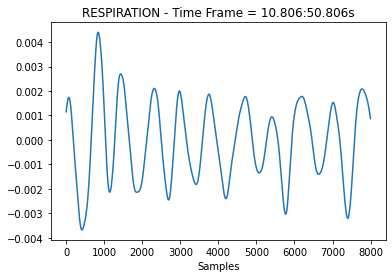

In [13]:
window_smooth_ms = 1000
resp = uniform_filter(resp, size=to_odd(int(window_smooth_ms * fs / 1000)))
resp_cut = resp[int(time_frame[0]*fs):int(time_frame[1]*fs)]
plt.plot(resp_cut)
plt.xlabel('Samples')
plt.title('RESPIRATION - Time Frame = ' +str(time_frame[0])+ ':' +str(time_frame[1])+ 's')

### Cleaning

Khodadad et al. (2018) <https://iopscience.iop.org/article/10.1088/1361-6579/aad7e6/meta>

BioSPPy <https://github.com/PIA-Group/BioSPPy/blob/master/biosppy/signals/resp.py>

Clean a respiration signal using different sets of parameters, such as 'khodadad2018' (linear detrending followed by a fifth order 2Hz low-pass IIR Butterworth filter) or 'BioSPPy' (second order 0.1 - 0.35 Hz bandpass Butterworth filter followed by a constant detrending).

Text(0.5, 1.0, 'RESPIRATION - Time Frame = 10.806:50.806s')

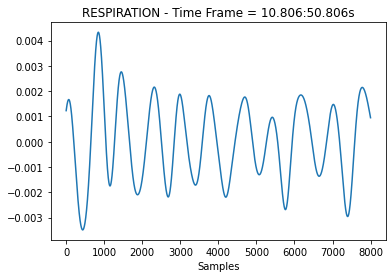

In [14]:
resp = nk.rsp.rsp_clean(resp)
resp_cut = resp[int(time_frame[0]*fs):int(time_frame[1]*fs)]
plt.plot(resp_cut)
plt.xlabel('Samples')
plt.title('RESPIRATION - Time Frame = ' +str(time_frame[0])+ ':' +str(time_frame[1])+ 's')

### Detrending

Text(0.5, 1.0, 'RESPIRATION - Time Frame = 10.806:50.806s')

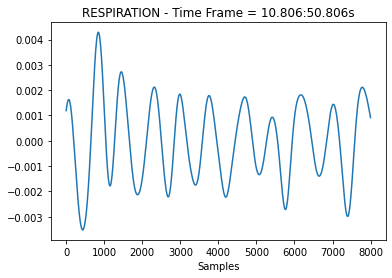

In [15]:
resp = detrend(resp)
resp_cut = resp[int(time_frame[0]*fs):int(time_frame[1]*fs)]
plt.plot(resp_cut)
plt.xlabel('Samples')
plt.title('RESPIRATION - Time Frame = ' +str(time_frame[0])+ ':' +str(time_frame[1])+ 's')

### Normalization

In [16]:
def scale_normalization(
    arr: np.ndarray,
    mode: Literal["range", "sum", "rss", "rms"] = "range",
    rg: Optional[Tuple[float, float]] = None,
) -> np.ndarray:
    """
    1D array
    """
    mx = np.max(arr)
    mn = np.min(arr)
    d = mx - mn
    if d == 0:
        return np.zeros_like(arr)
    s = arr - mn
    if mode == "range":
        if rg is None:
            rg = 0.0, 1.0
        ba = rg[1] - rg[0]
        a = rg[0]
        return (s * ba / d) + a
    elif mode == "sum":
        return s / np.sum(s)
    elif mode == "rss":
        return s / np.sqrt(np.sum(np.square(s)))
    elif mode == "rms":
        return s / np.sqrt(np.sum(np.square(s)) / len(s))

Text(0.5, 1.0, 'RESPIRATION - Time Frame = 10.806:50.806s')

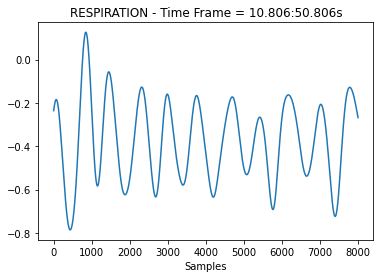

In [17]:
resp = scale_normalization(resp, rg=(-1, 1))
resp_cut = resp[int(time_frame[0]*fs):int(time_frame[1]*fs)]
plt.plot(resp_cut)
plt.xlabel('Samples')
plt.title('RESPIRATION - Time Frame = ' +str(time_frame[0])+ ':' +str(time_frame[1])+ 's')

### Standardization

In [18]:
def interquartile_range(
    arr: np.ndarray, q: Optional[Sequence[Number]] = None, axis: int = 0
) -> float:
    """
    1D array
    """
    if q is None:
        q = [25, 75]
    return st.iqr(arr, axis=axis, rng=q, nan_policy="omit")

def scale_standardization_robust(
    arr: np.ndarray, q: Optional[Sequence[Number]] = None, axis: int = 0
) -> np.ndarray:
    return (arr - np.median(arr, axis=axis)) / interquartile_range(arr, q, axis=axis)

Text(0.5, 1.0, 'RESPIRATION - Time Frame = 10.806:50.806s')

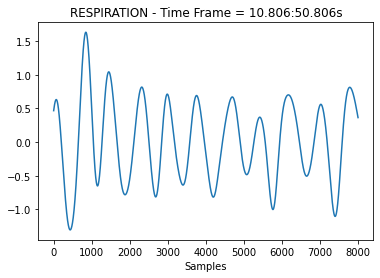

In [19]:
resp = scale_standardization_robust(resp)
resp_cut = resp[int(time_frame[0]*fs):int(time_frame[1]*fs)]
plt.plot(resp_cut)
plt.xlabel('Samples')
plt.title('RESPIRATION - Time Frame = ' +str(time_frame[0])+ ':' +str(time_frame[1])+ 's')

### Correction Respiration Sign

In [20]:
def _correct_rsp_sign(
    rsp: np.ndarray, fs: int, distance_ms: int, prominence: float
) -> np.ndarray:
    distance = int(distance_ms * fs / 1000)
    rsp_max_idx, _ = find_peaks(rsp, distance=distance, prominence=prominence)
    rsp_min_idx, _ = find_peaks(-rsp, distance=distance, prominence=prominence)

    i = 0
    j = 0
    lengths_min_max = []
    lengths_max_min = []

    prev_min_max = False
    prev_max_min = False

    while i < len(rsp_min_idx) and j < len(rsp_max_idx):
        min_i = rsp_min_idx[i]
        max_j = rsp_max_idx[j]

        if min_i < max_j:
            length = max_j - min_i
            if not prev_min_max:
                lengths_min_max.append(length)
            prev_min_max = True
            prev_max_min = False
            i += 1
        else:
            length = min_i - max_j
            if not prev_max_min:
                lengths_max_min.append(length)
            prev_min_max = False
            prev_max_min = True
            j += 1

    length_med_min_max = np.median(lengths_min_max)
    length_med_max_min = np.median(lengths_max_min)

    if length_med_min_max > length_med_max_min:
        rsp_corr = -rsp
    else:
        rsp_corr = rsp

    return rsp_corr

Text(0.5, 1.0, 'RESPIRATION - Time Frame = 10.806:50.806s')

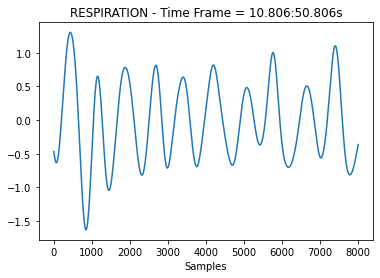

In [21]:
distance_ms = 1000
prominence = 0.25
resp = _correct_rsp_sign(resp, fs, distance_ms=distance_ms, prominence=prominence)
resp_cut = resp[int(time_frame[0]*fs):int(time_frame[1]*fs)]
plt.plot(resp_cut)
plt.xlabel('Samples')
plt.title('RESPIRATION - Time Frame = ' +str(time_frame[0])+ ':' +str(time_frame[1])+ 's')

## RESPIRATION PERIOD COMPUTATION

In [22]:
time_points = [10.806, 50.806, 110.806, 190.806, 290.806]
time_frames = [[time_points[i], time_points[i + 1]]
        for i in range(len(time_points) - 1)]

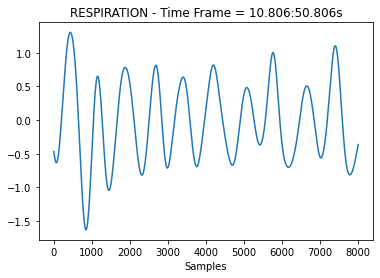

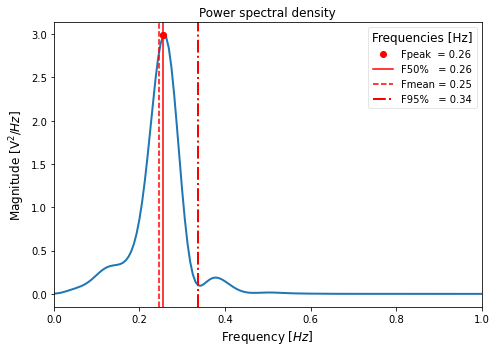

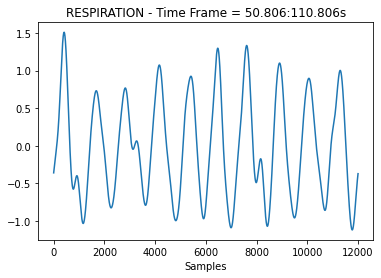

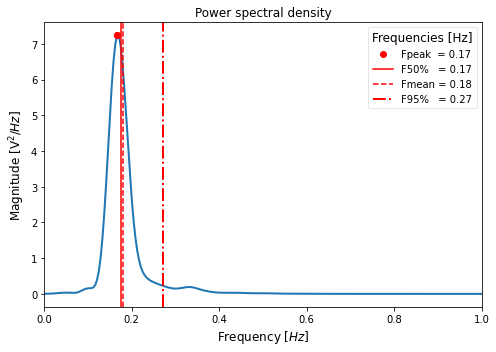

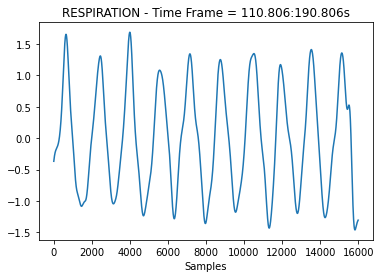

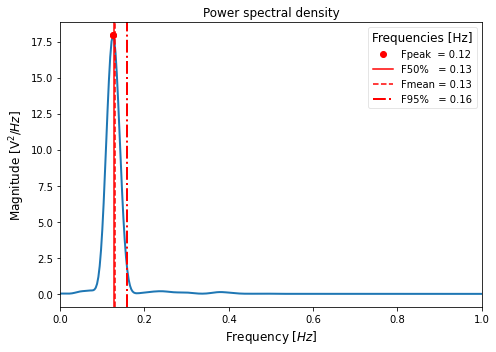

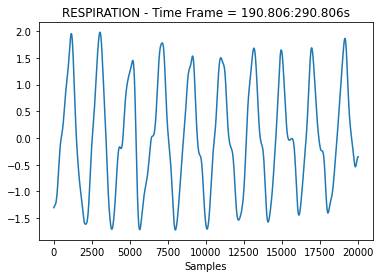

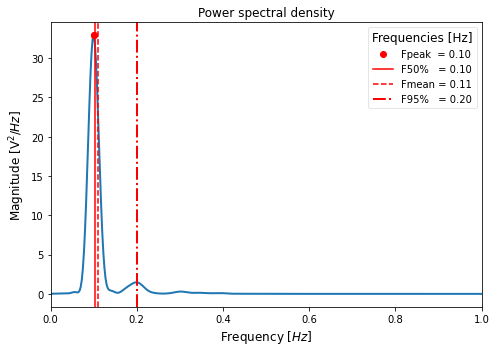

In [23]:
resp_period_all_comp = []

for k in time_frames:
    resp_cut = resp[int(k[0]*fs):int(k[1]*fs)]
    plt.figure()
    plt.plot(resp_cut)
    plt.xlabel('Samples')
    plt.title('RESPIRATION - Time Frame = ' +str(k[0])+ ':' +str(k[1])+ 's')
    fpcntile, mpf, fmax, Ptotal, f, P = psd2(resp_cut-np.mean(resp_cut), fs=fs, nfft=8*np.ceil(len(resp_cut)/2), show=True, xlim=(0, 1))
    resp_period = 1/fmax
    resp_period_all_comp.append(resp_period)

Text(0.5, 1.0, 'Sub-A/BDC9/K-ICB_A_BDC9_20190331-111511_BKe5wNpmMCVETk\nMAE: 0.02s')

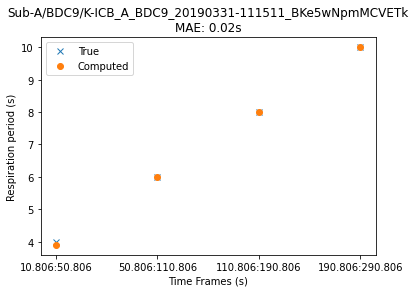

In [24]:
main_path = os.path.normpath(measurement)
sec_path = main_path.split(os.sep)
sec_path = sec_path[7]+'/'+sec_path[8]+'/'+sec_path[9]

resp_period_all_true = [4, 6, 8, 10]
err = mean_absolute_error(resp_period_all_true, resp_period_all_comp)
plt.figure()
x = np.array([0,1,2,3])
my_xticks = ['10.806:50.806','50.806:110.806','110.806:190.806','190.806:290.806']
plt.xticks(x, my_xticks)
plt.plot(my_xticks, resp_period_all_true, 'x')
plt.plot(my_xticks, resp_period_all_comp, 'o')
plt.xlabel('Time Frames (s)')
plt.ylabel("Respiration period (s)")
plt.legend(['True', 'Computed'])
plt.title(sec_path+ '\nMAE: ' +str(format(err, ".2f"))+ 's')

For all measurements.

In [25]:
del path_all[96]
del path_all[227]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


/tmp/ipykernel_38210/1441949628.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122


/home/giuseppeditursi/.cache/pypoetry/virtualenvs/kino-core-7fM3i_G6-py3.9/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/giuseppeditursi/.cache/pypoetry/virtualenvs/kino-core-7fM3i_G6-py3.9/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263


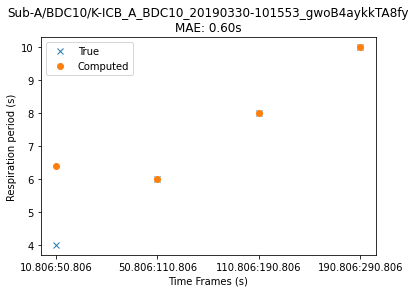

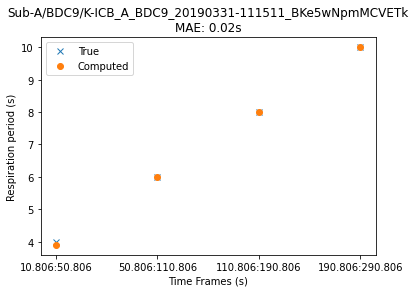

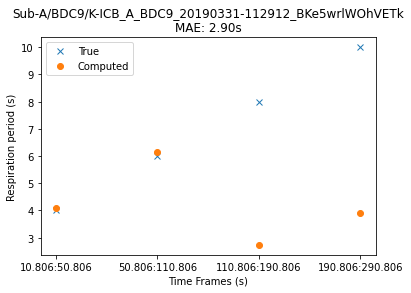

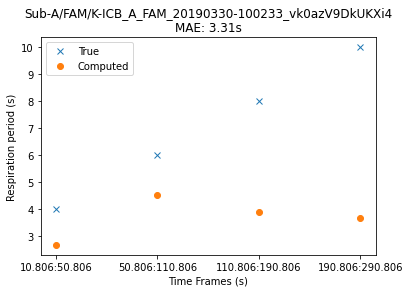

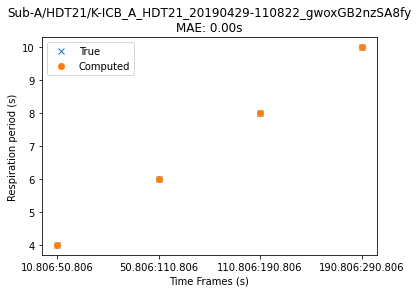

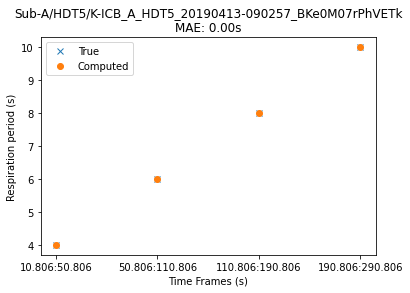

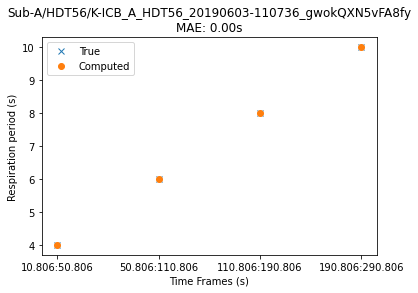

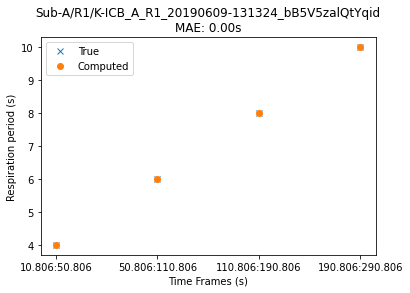

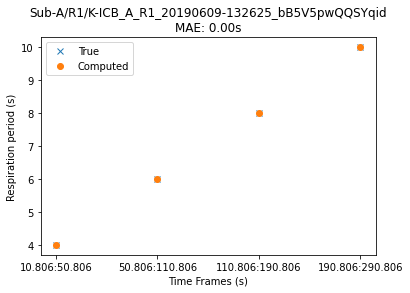

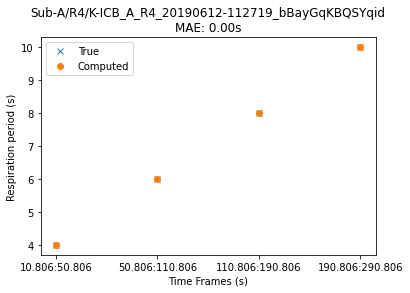

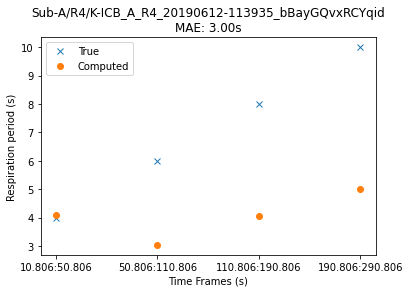

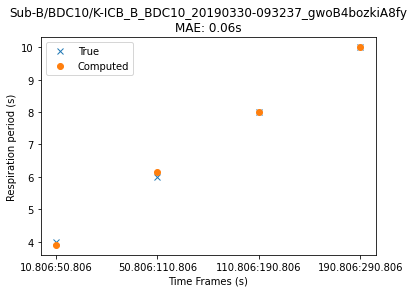

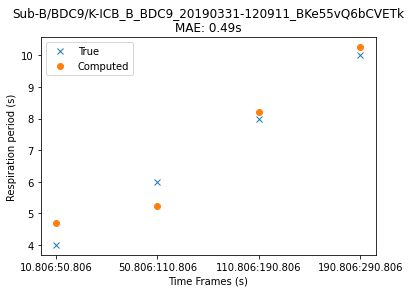

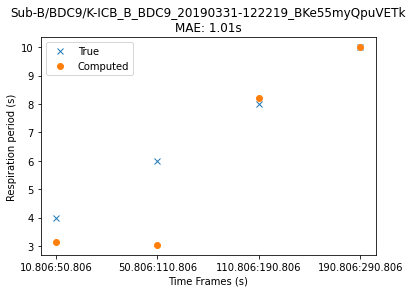

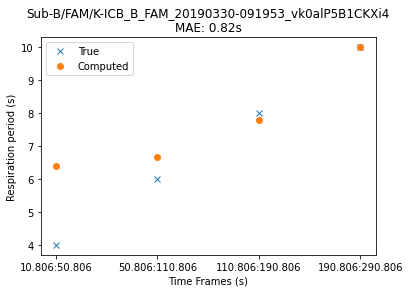

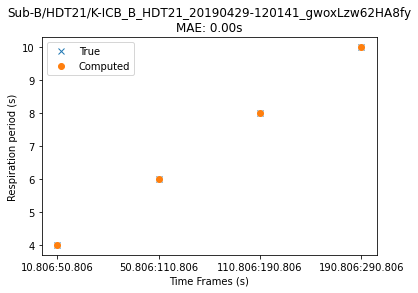

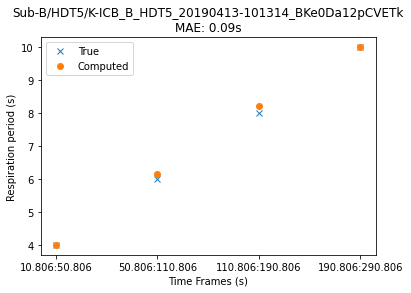

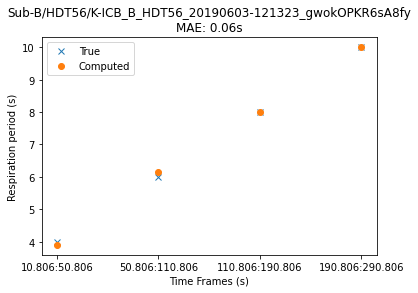

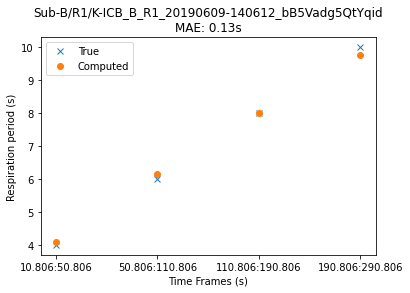

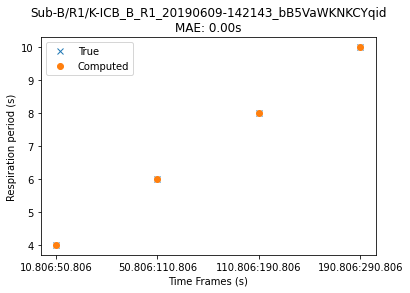

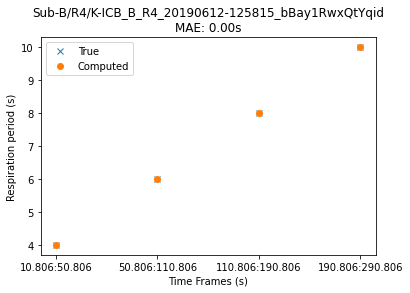

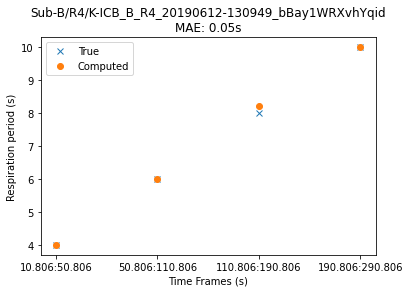

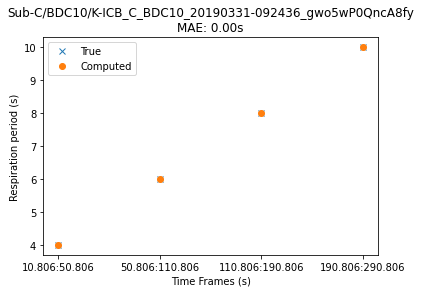

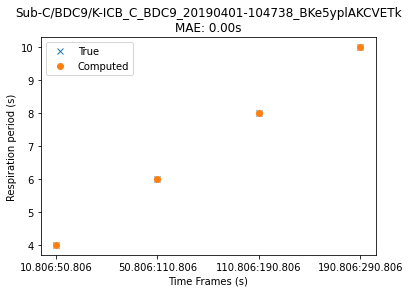

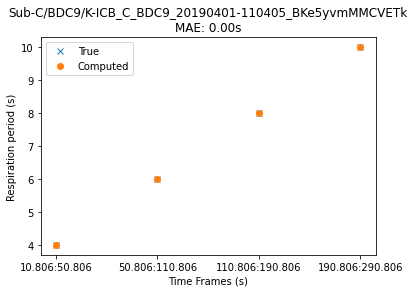

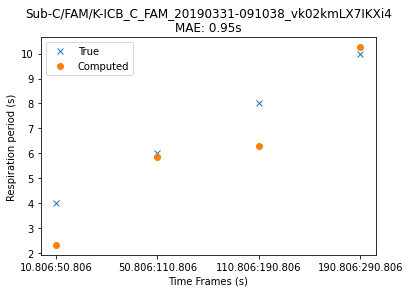

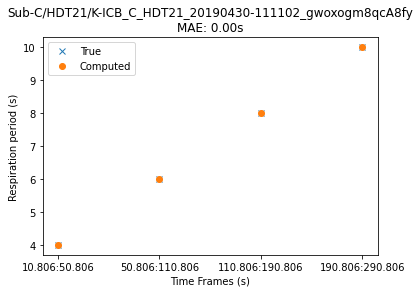

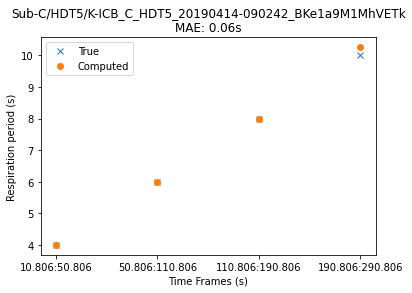

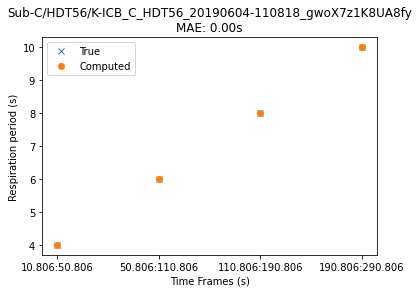

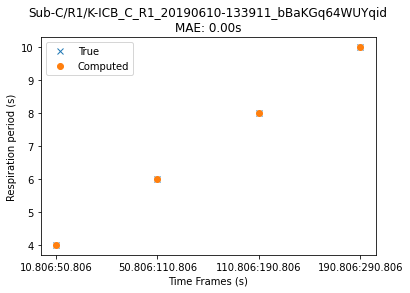

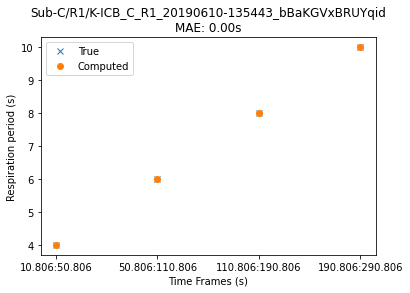

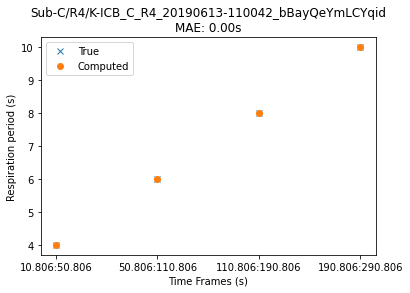

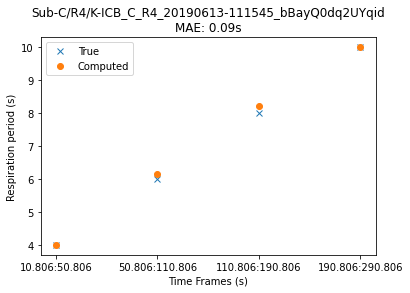

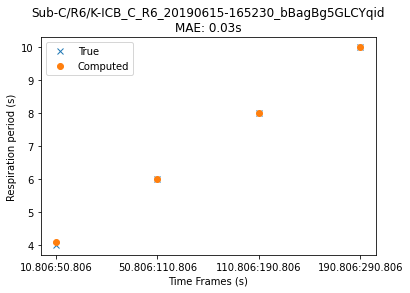

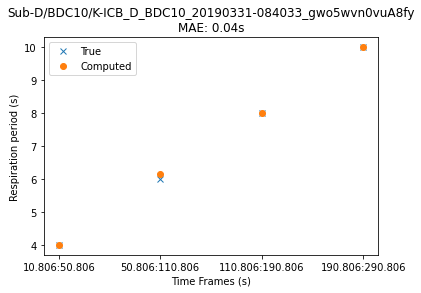

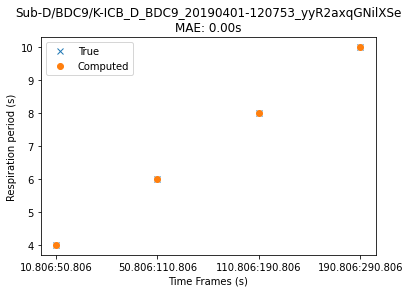

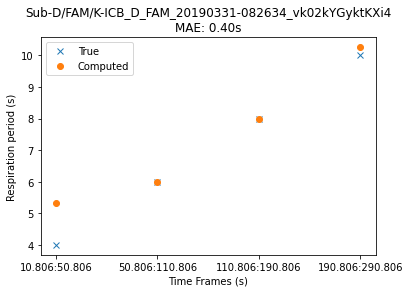

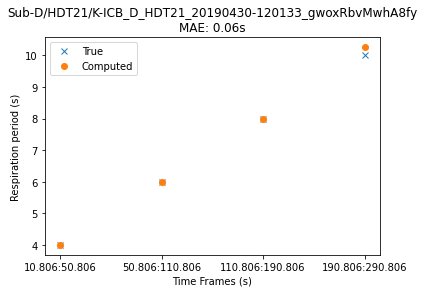

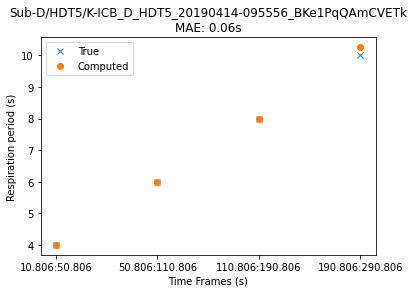

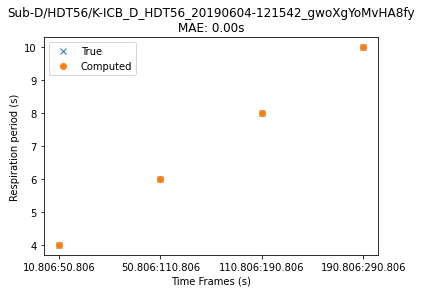

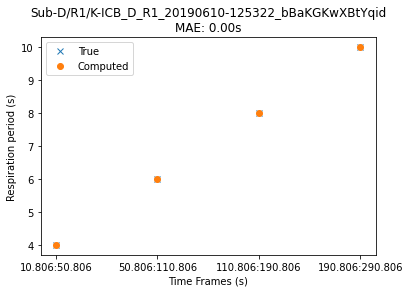

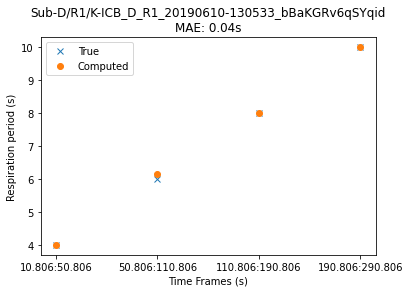

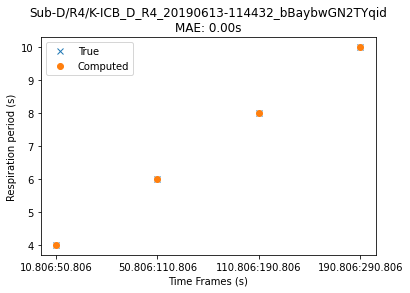

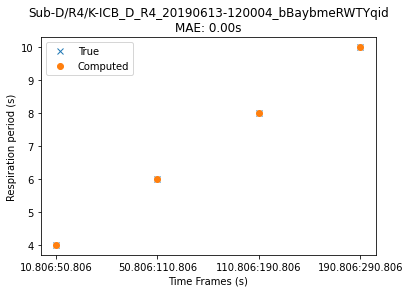

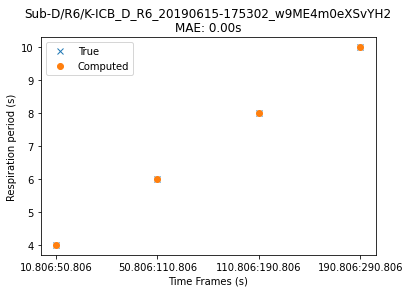

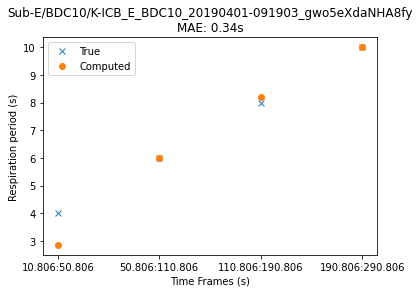

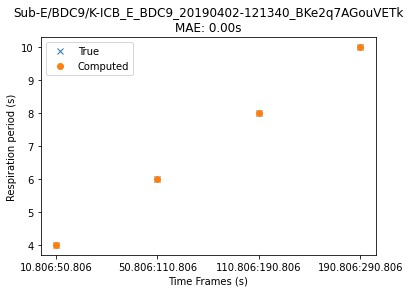

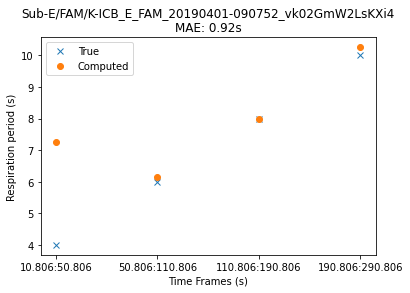

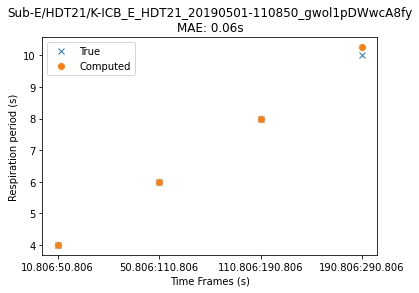

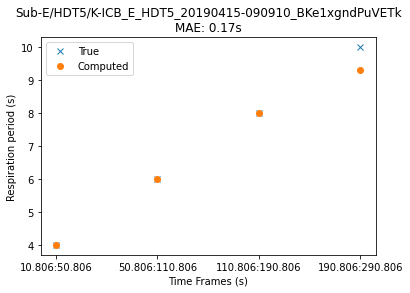

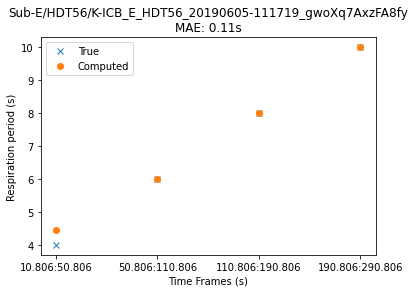

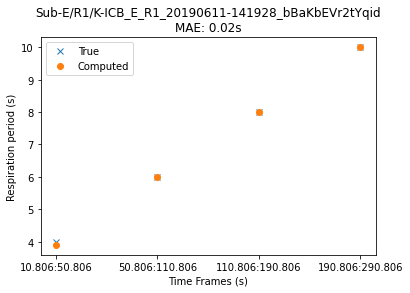

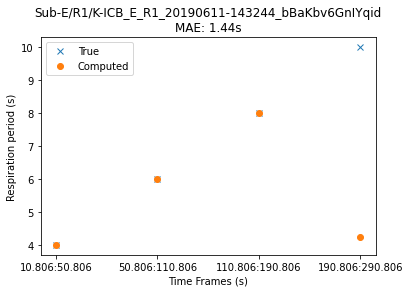

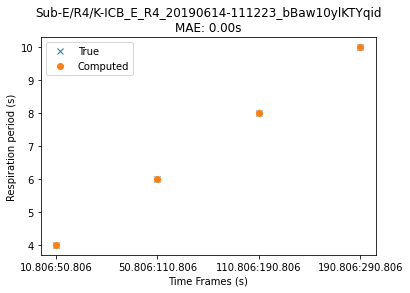

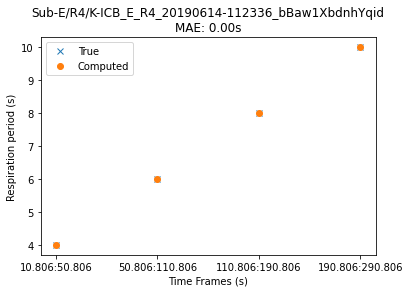

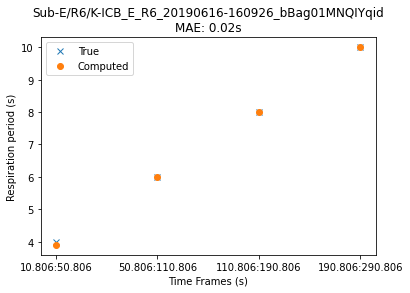

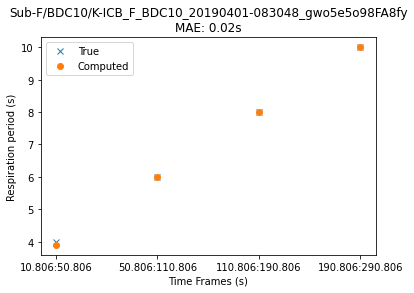

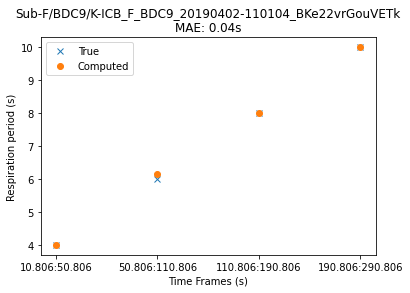

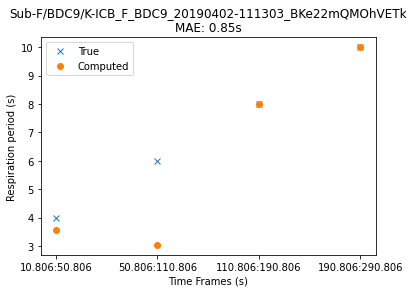

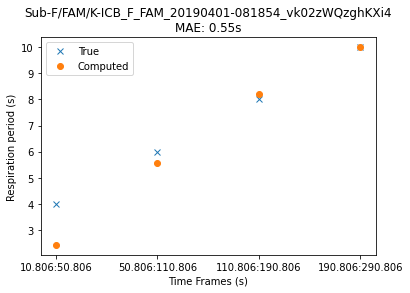

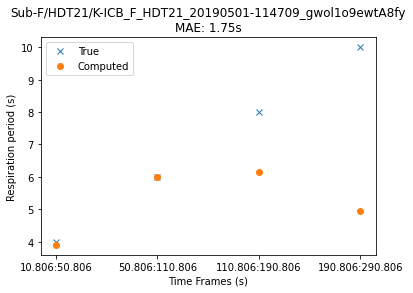

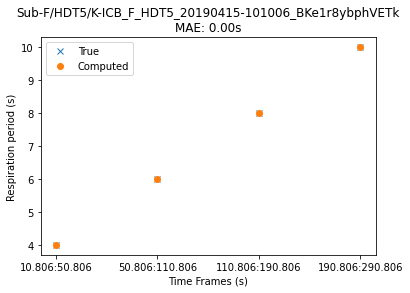

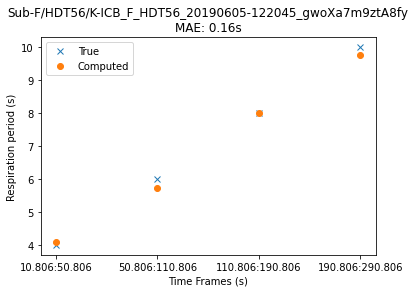

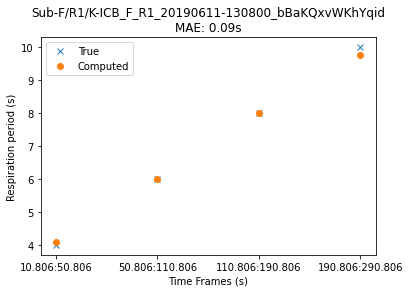

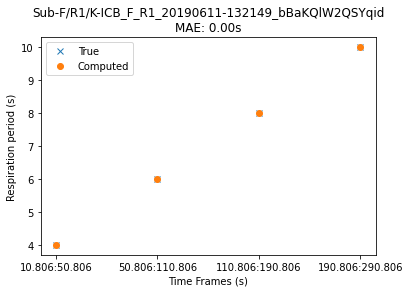

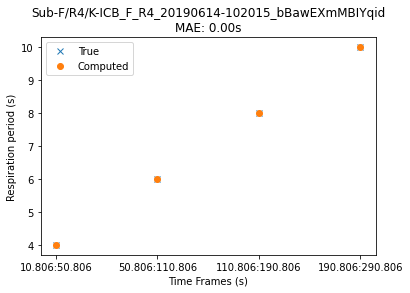

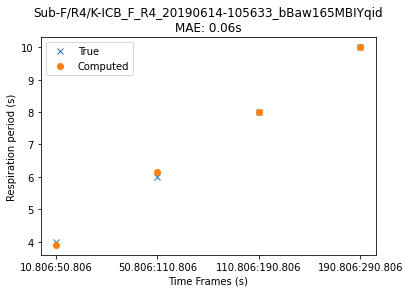

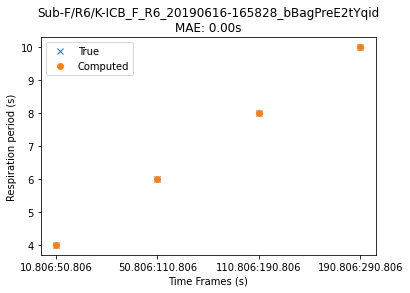

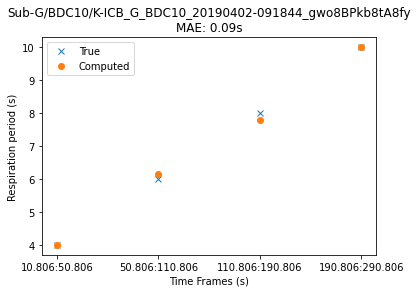

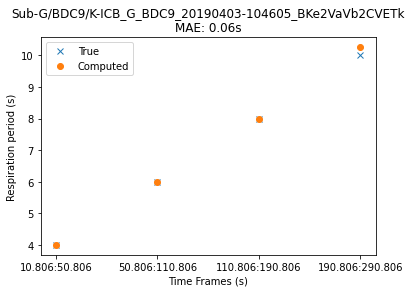

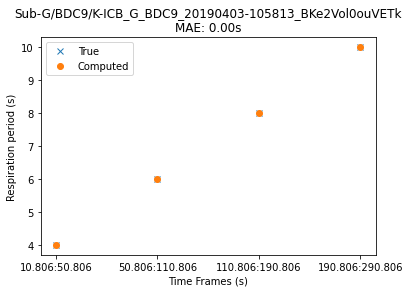

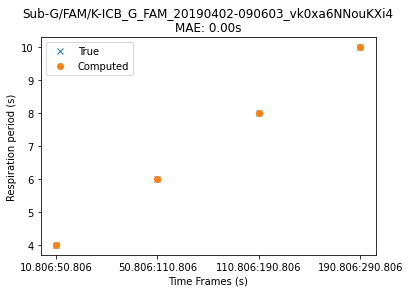

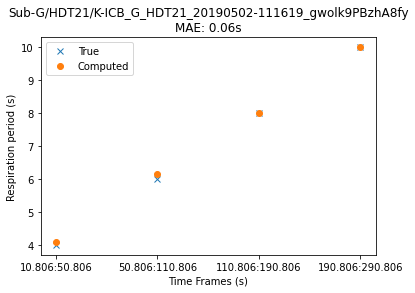

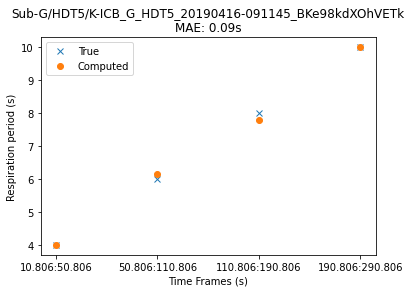

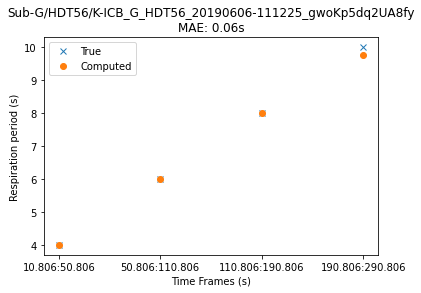

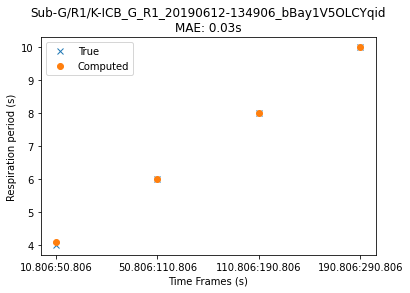

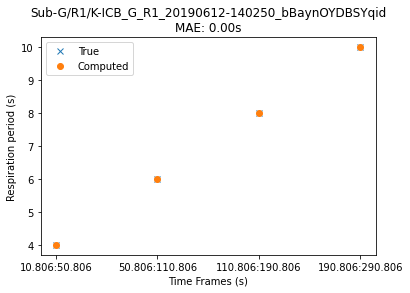

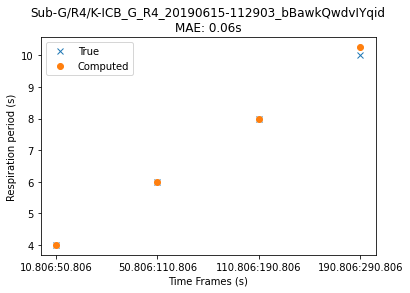

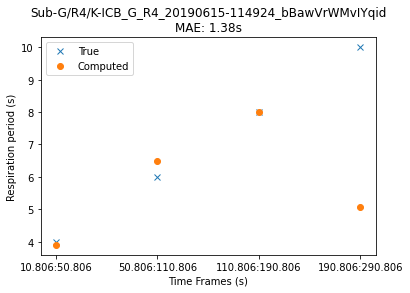

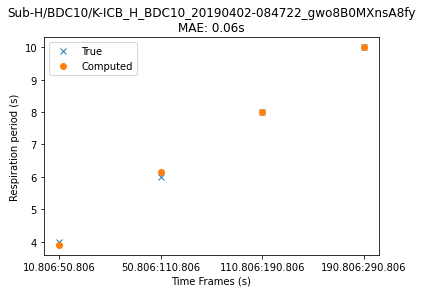

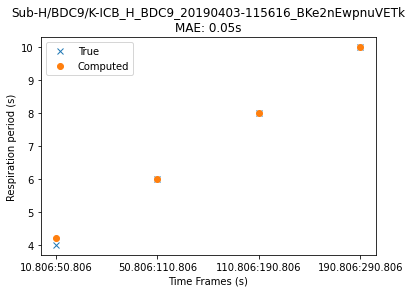

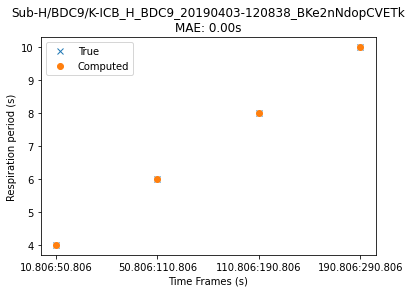

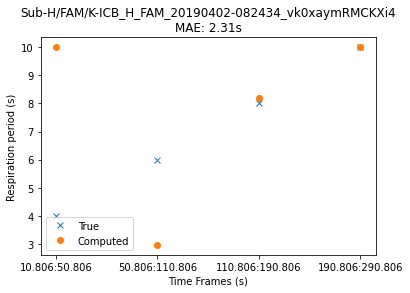

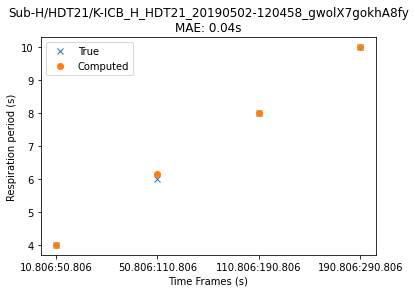

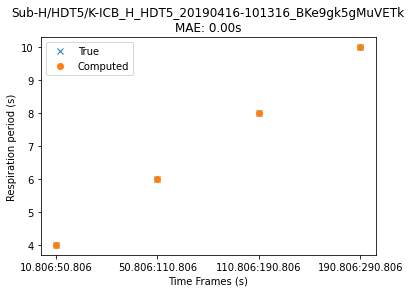

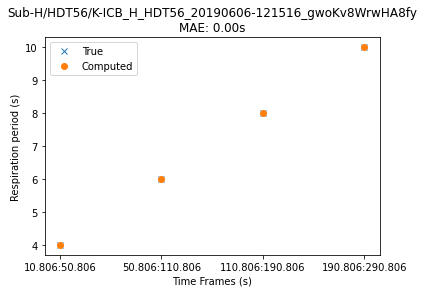

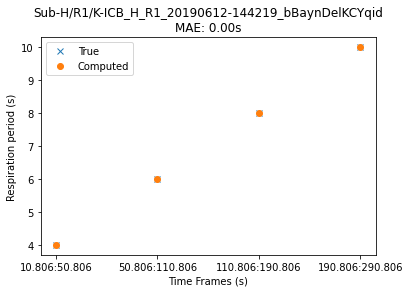

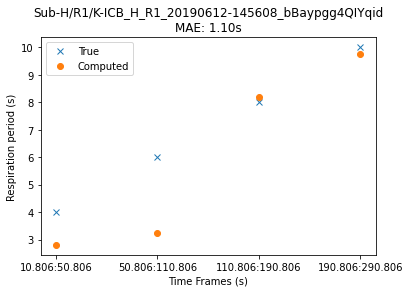

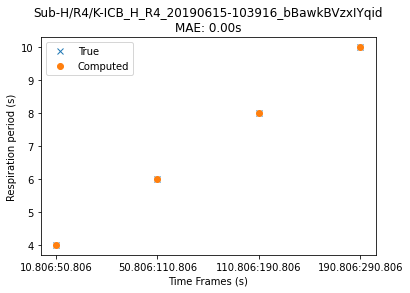

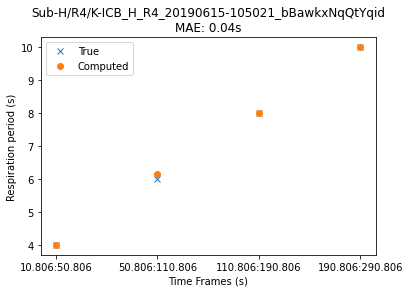

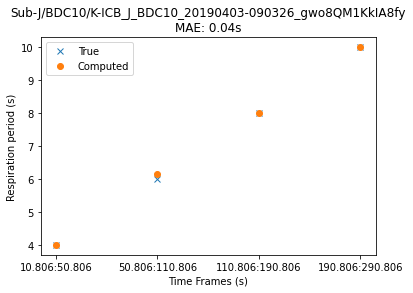

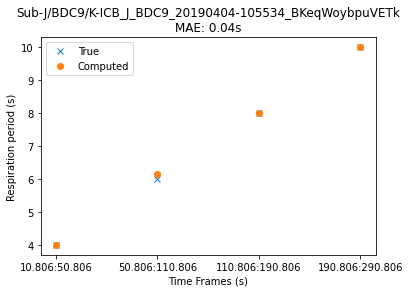

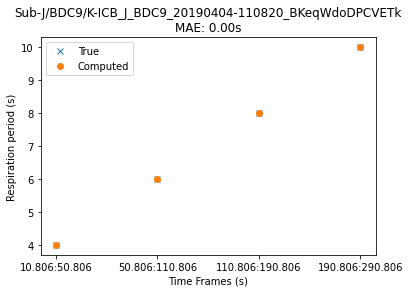

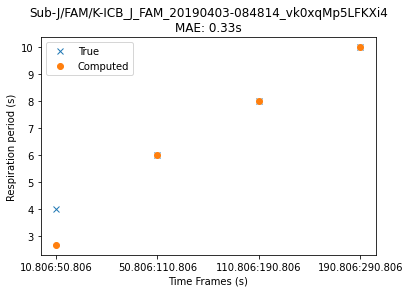

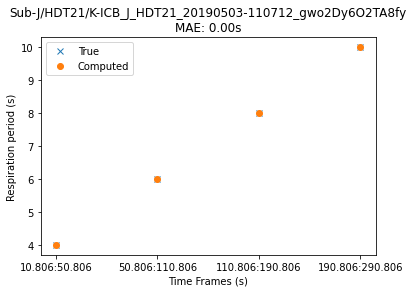

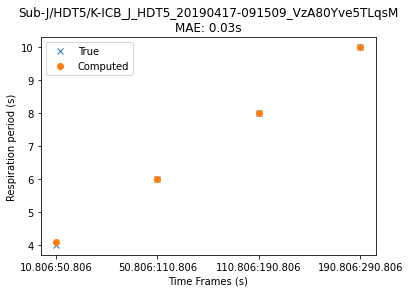

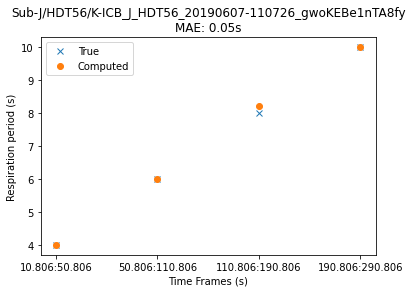

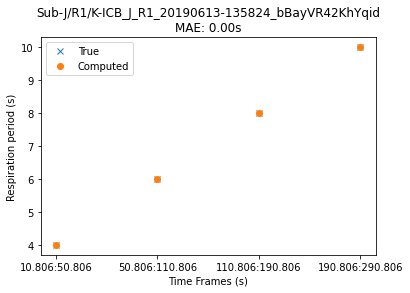

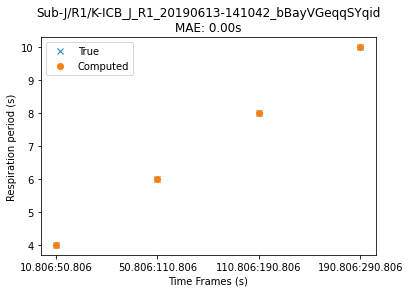

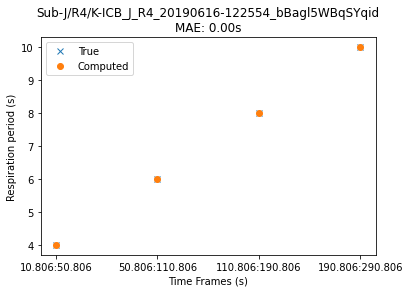

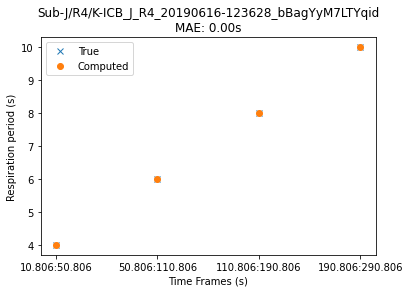

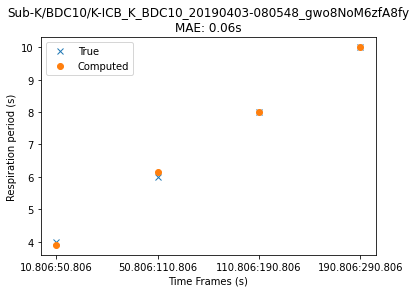

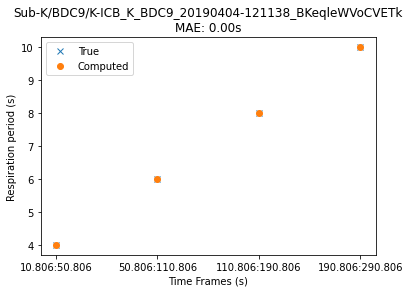

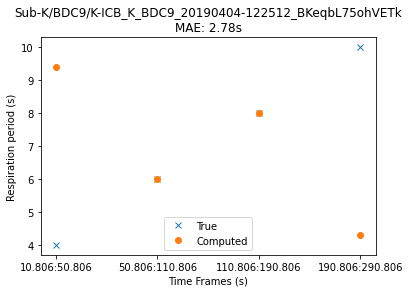

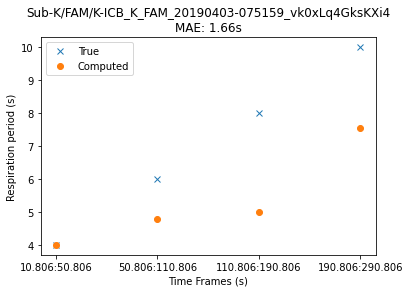

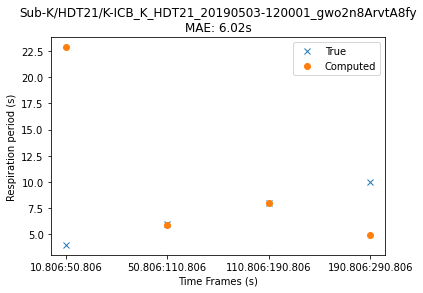

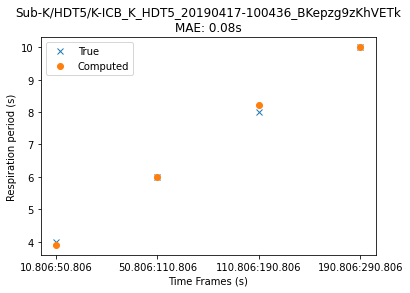

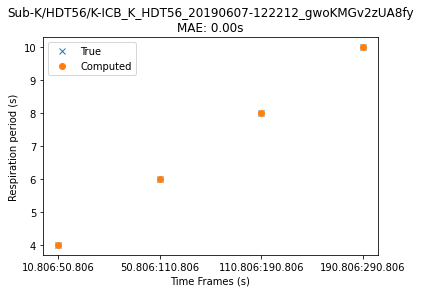

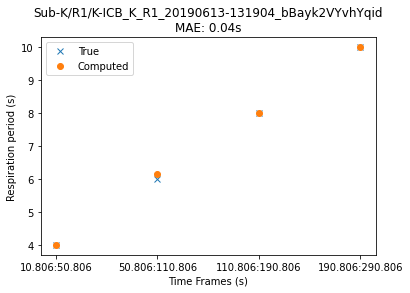

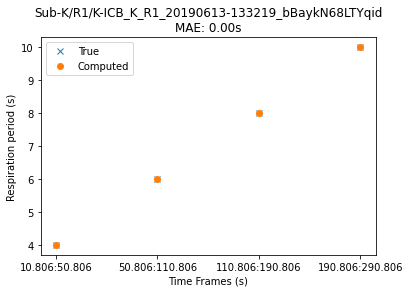

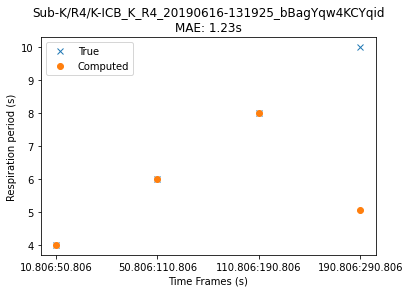

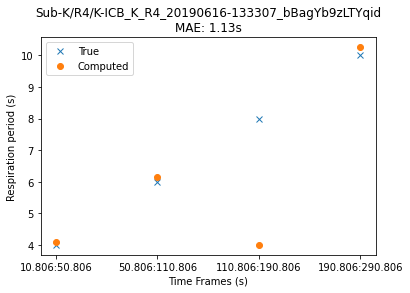

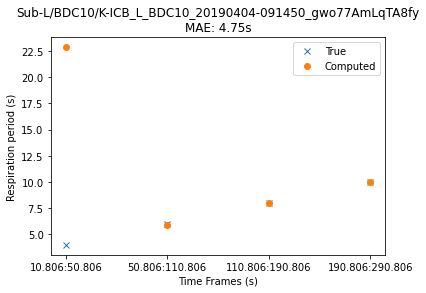

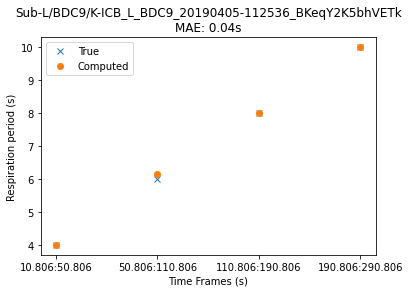

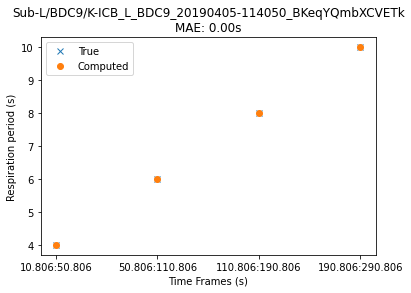

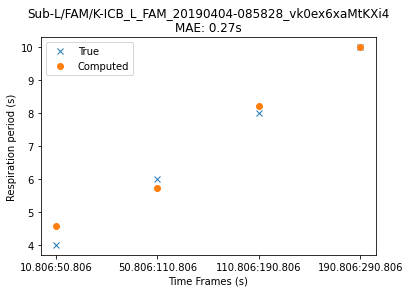

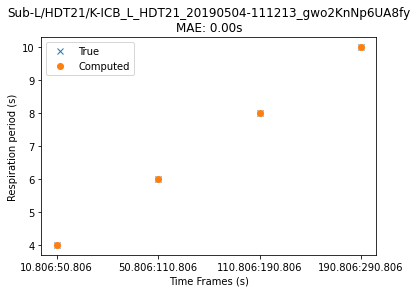

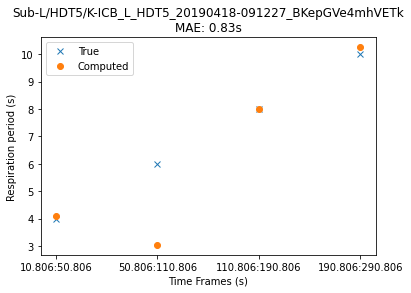

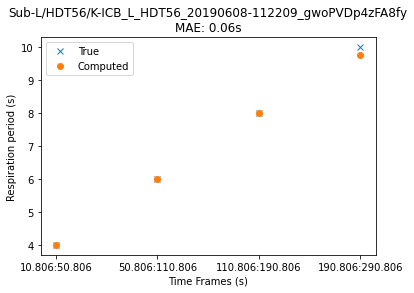

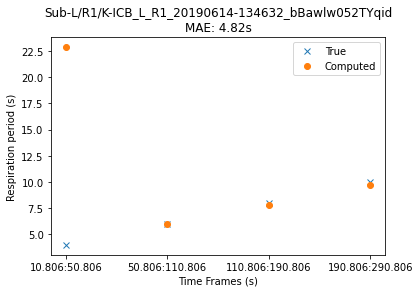

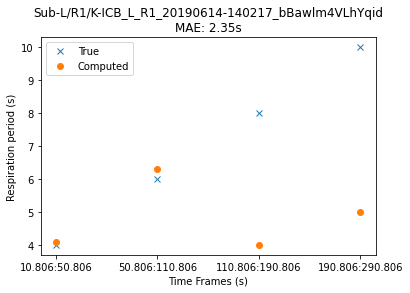

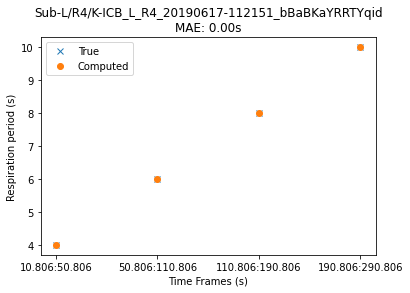

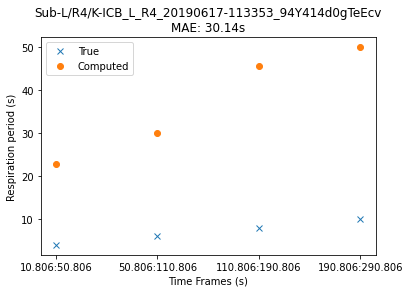

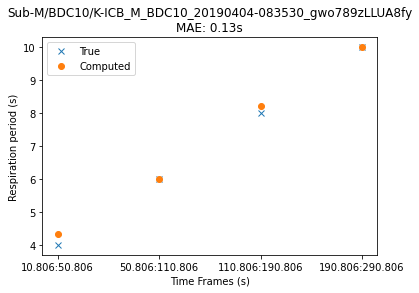

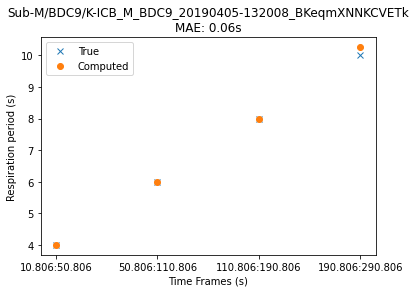

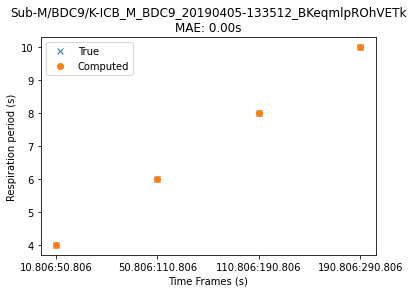

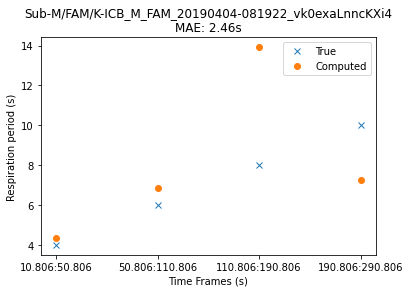

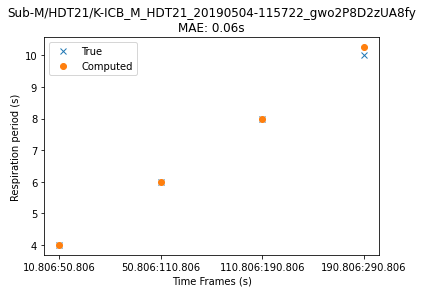

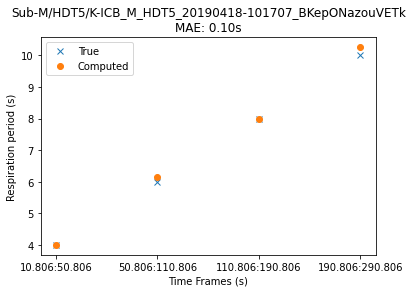

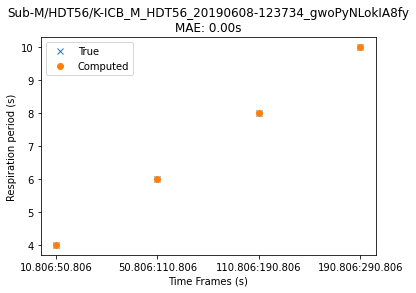

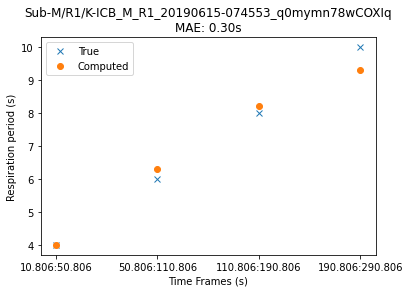

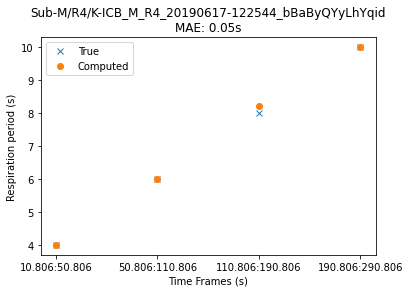

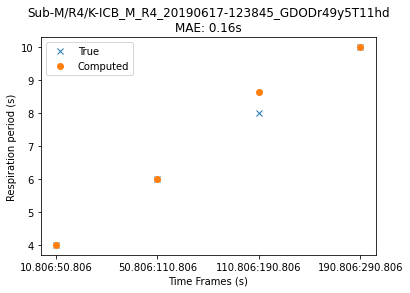

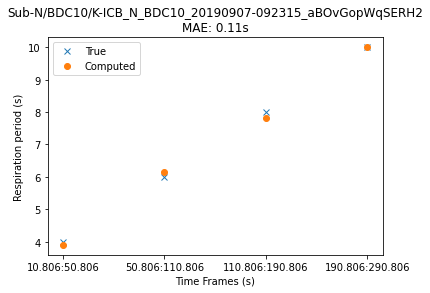

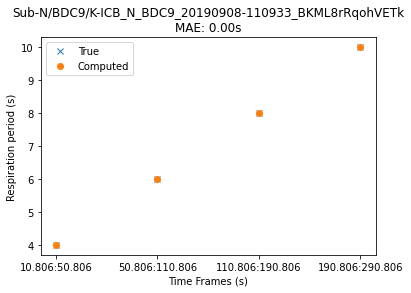

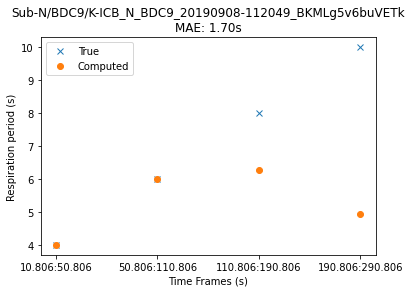

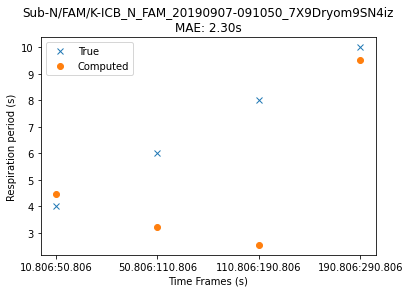

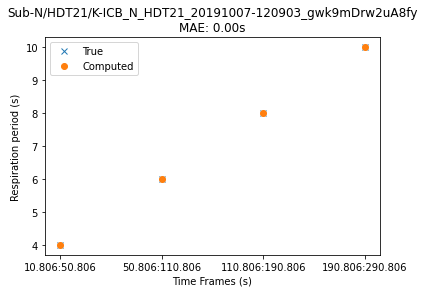

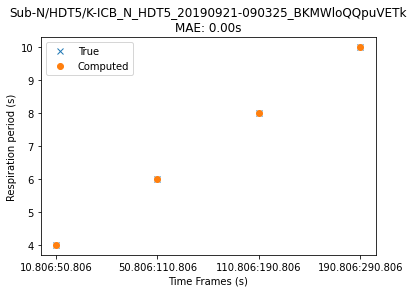

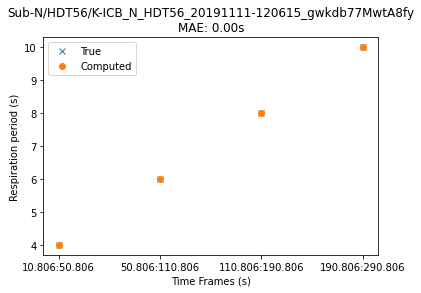

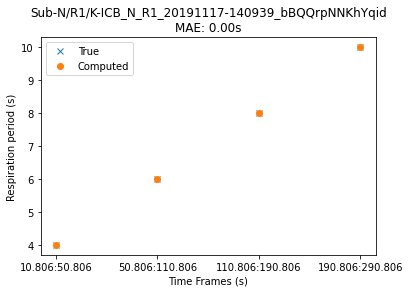

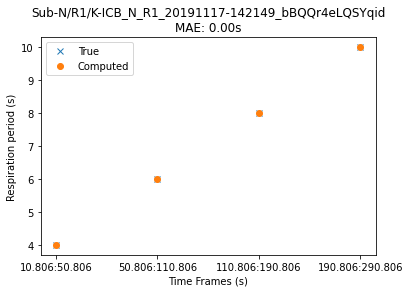

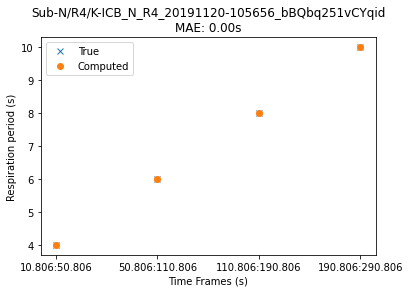

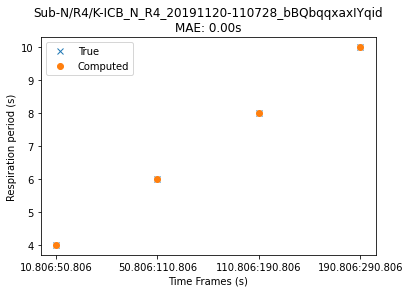

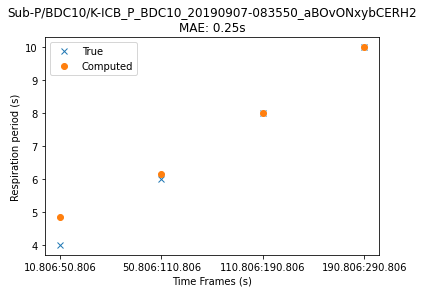

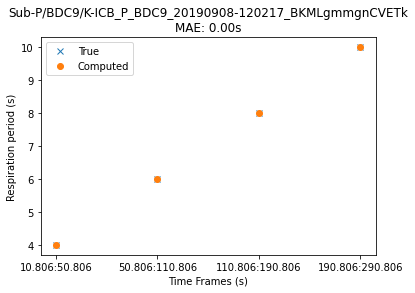

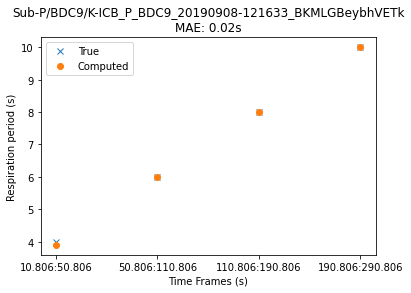

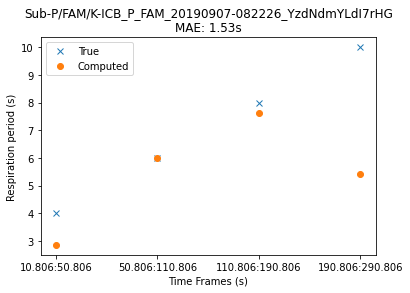

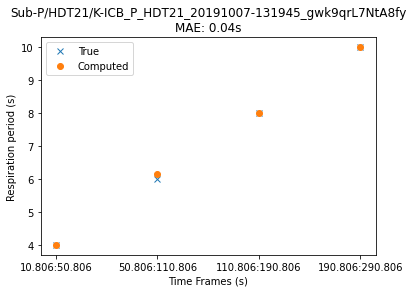

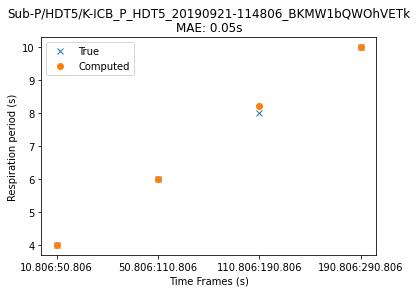

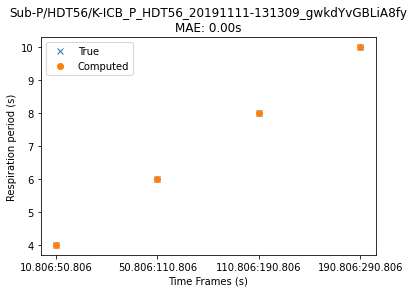

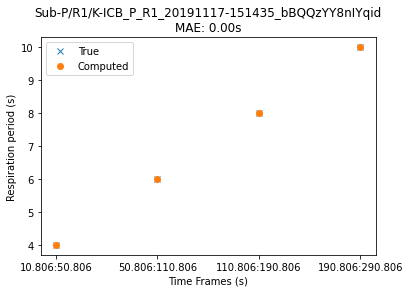

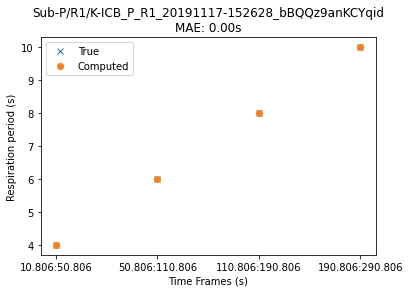

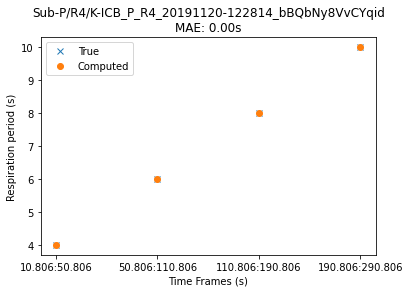

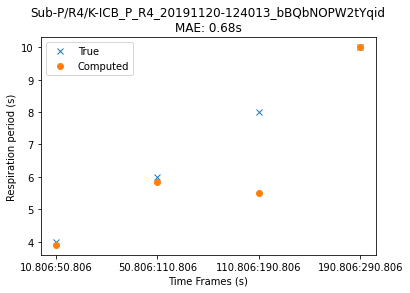

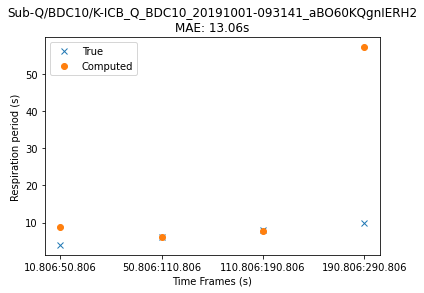

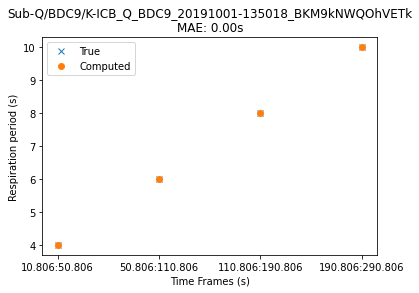

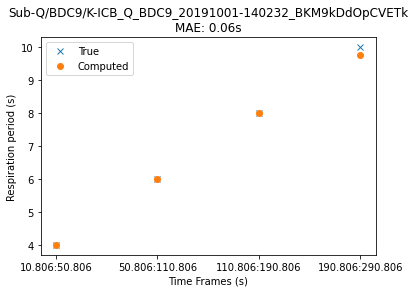

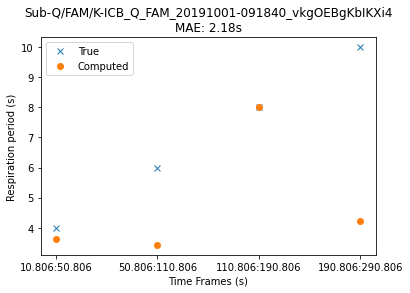

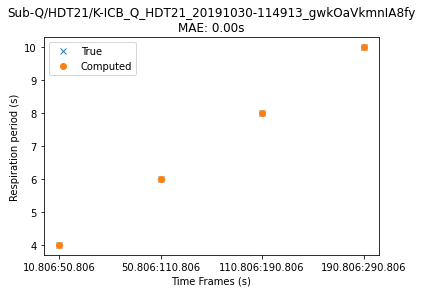

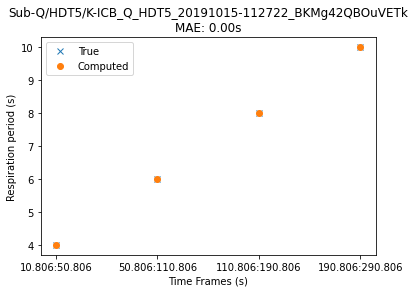

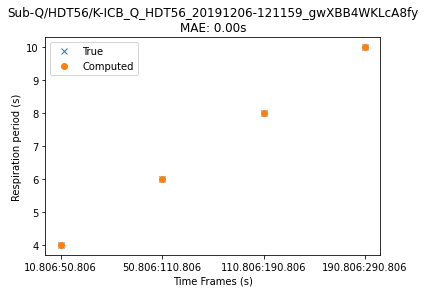

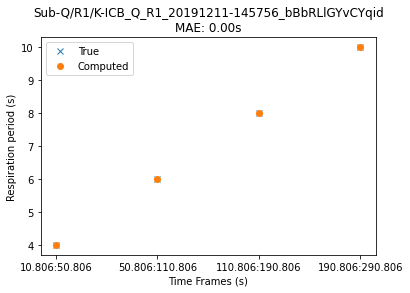

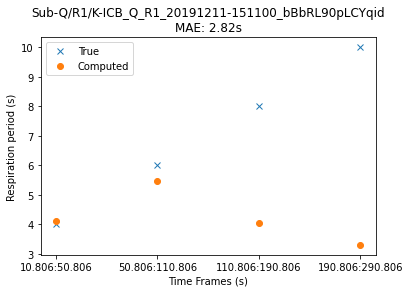

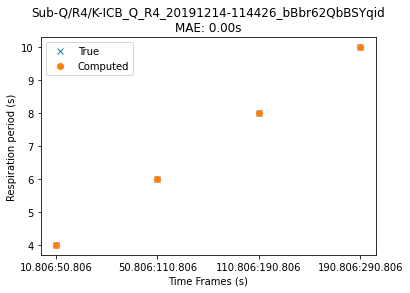

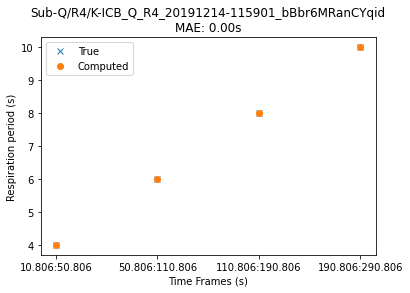

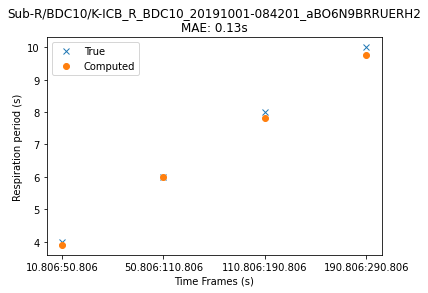

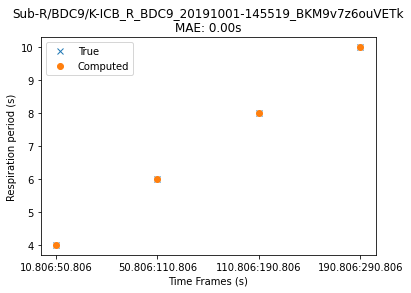

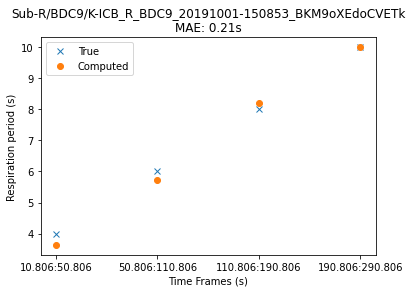

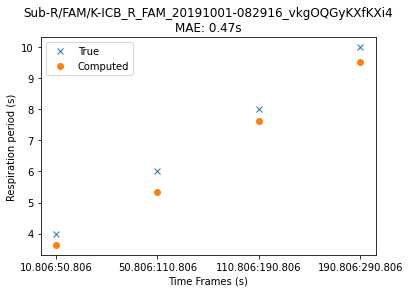

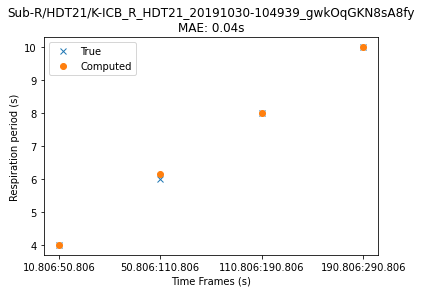

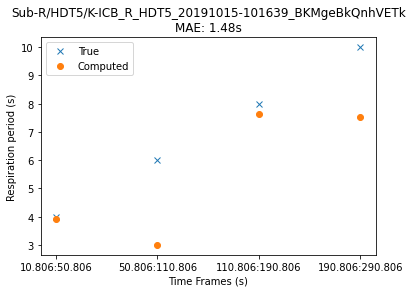

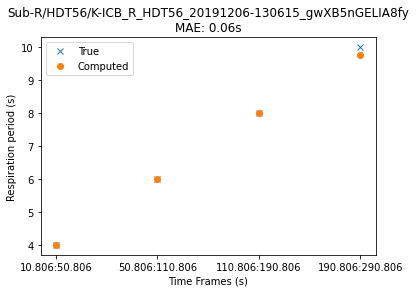

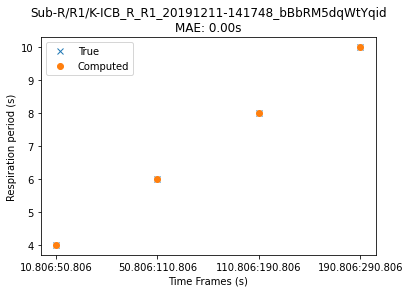

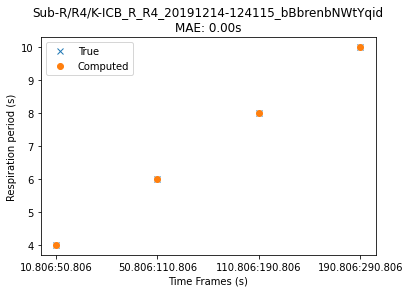

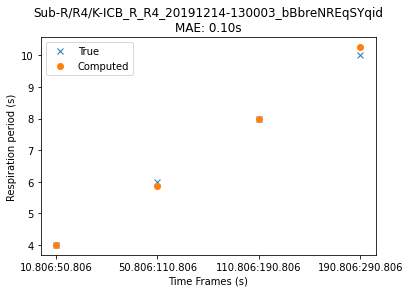

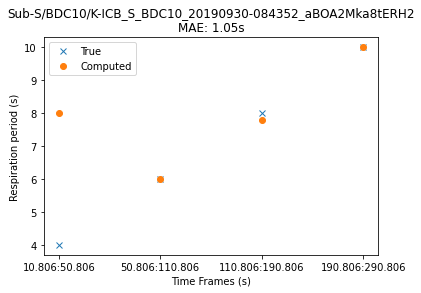

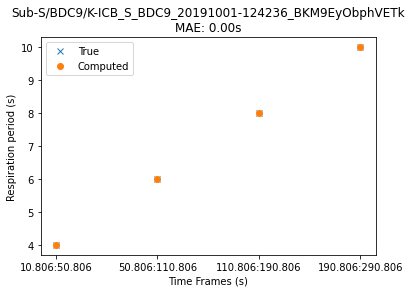

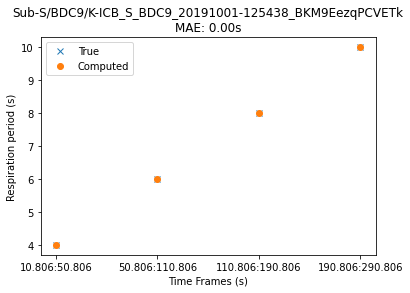

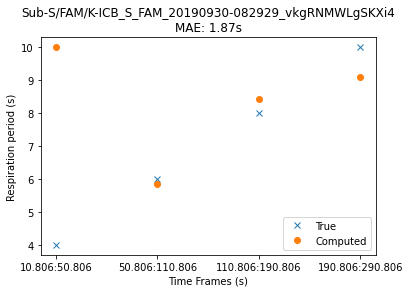

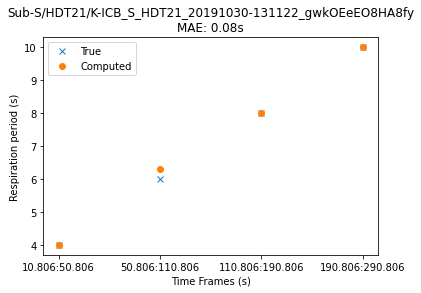

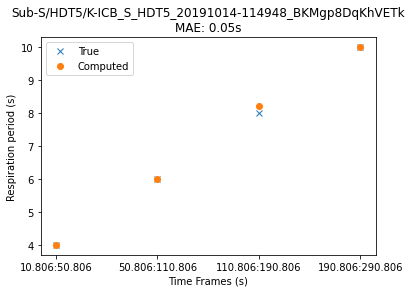

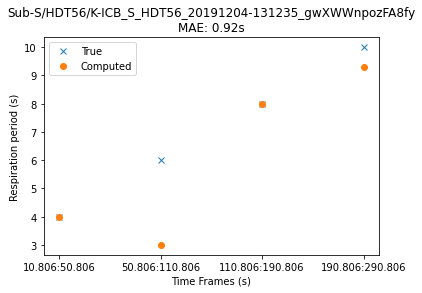

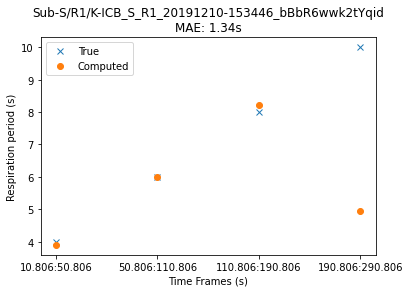

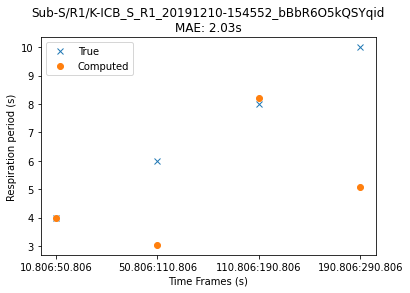

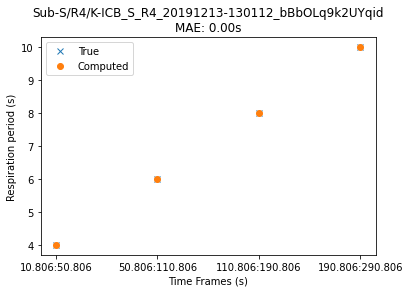

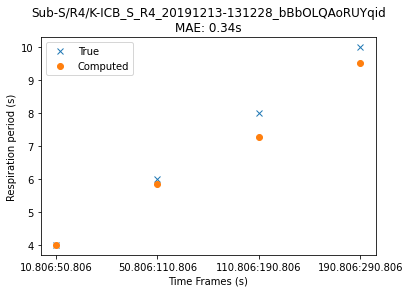

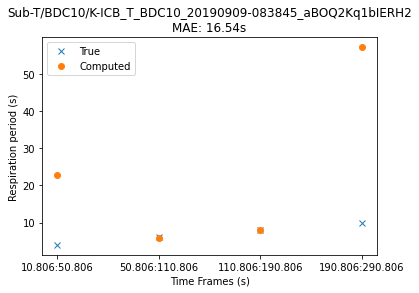

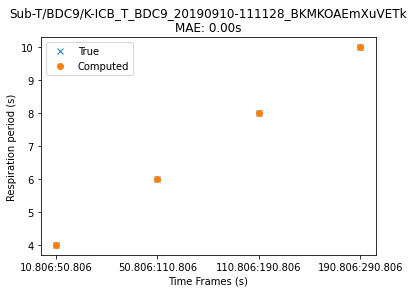

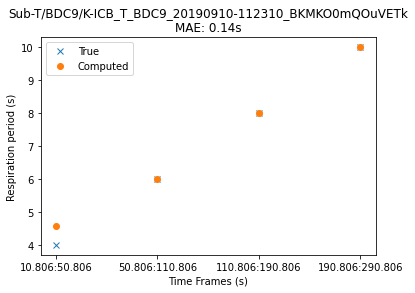

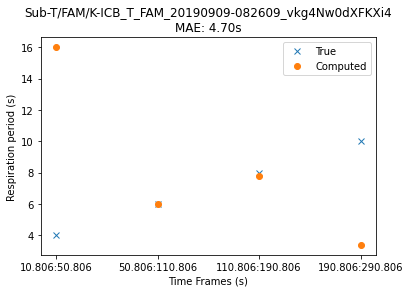

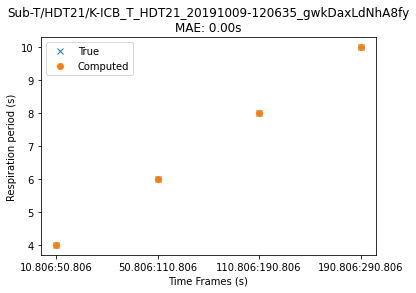

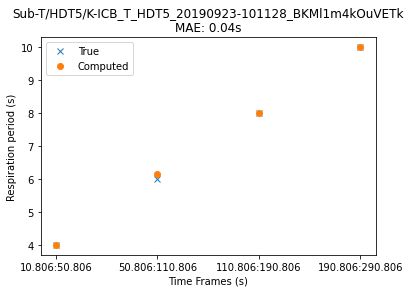

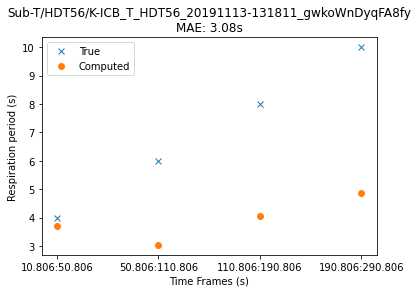

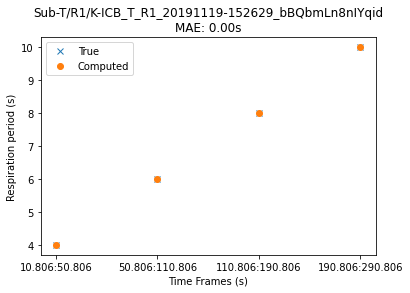

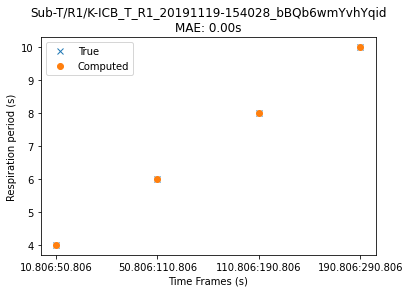

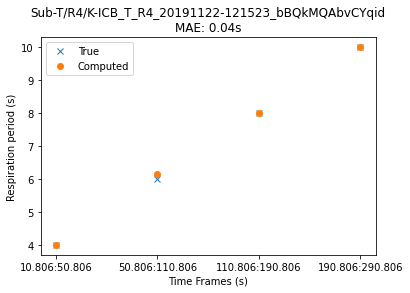

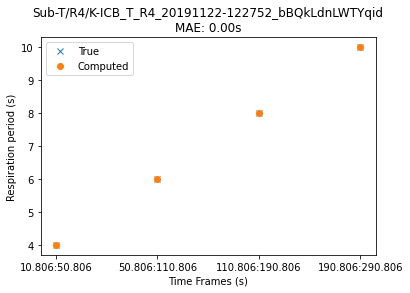

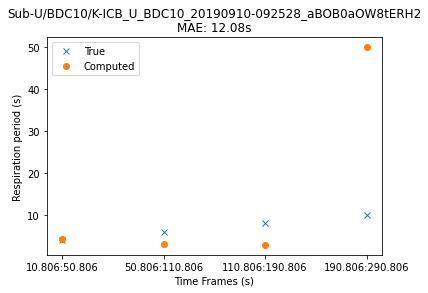

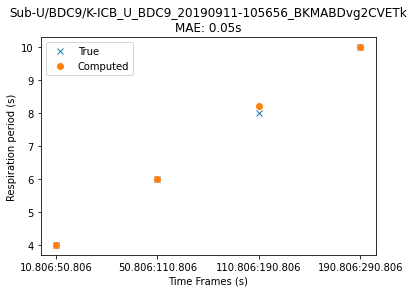

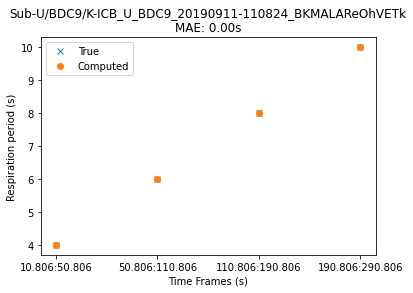

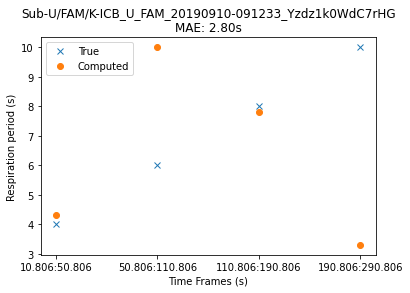

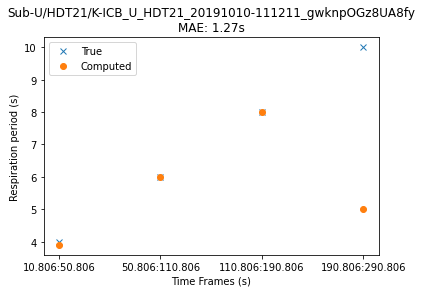

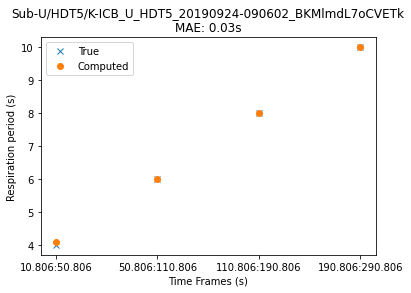

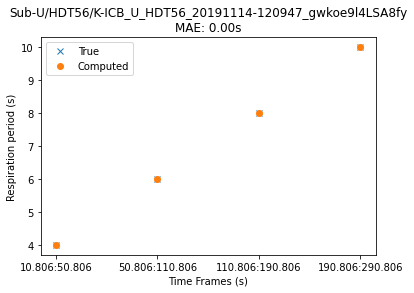

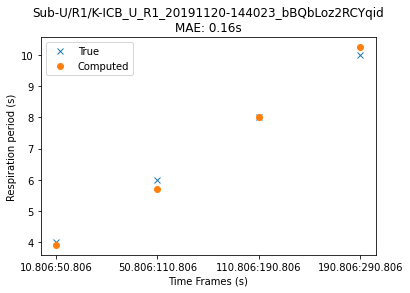

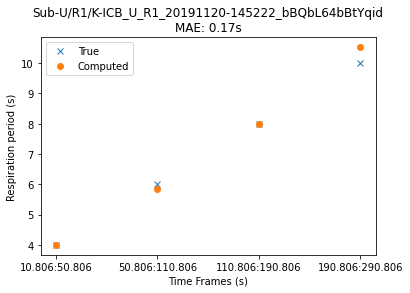

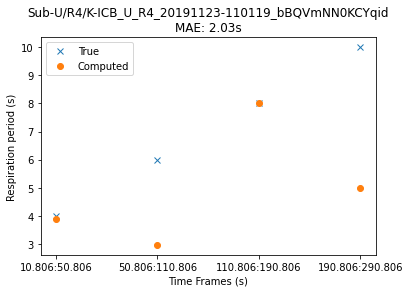

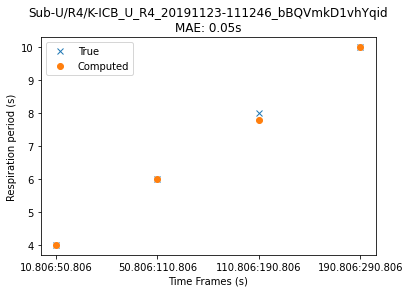

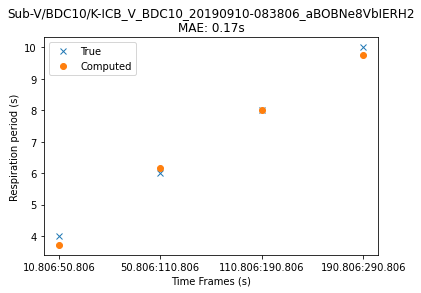

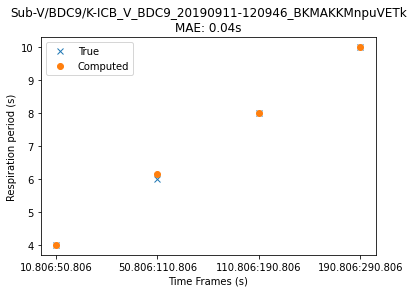

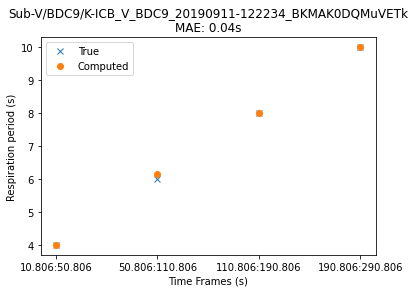

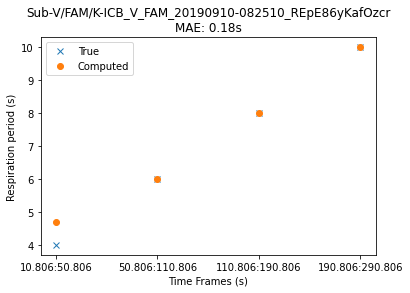

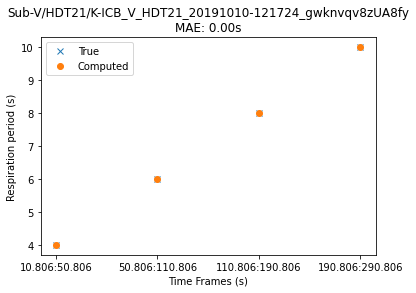

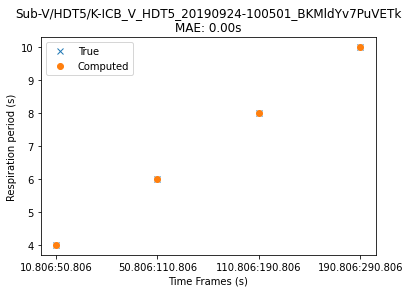

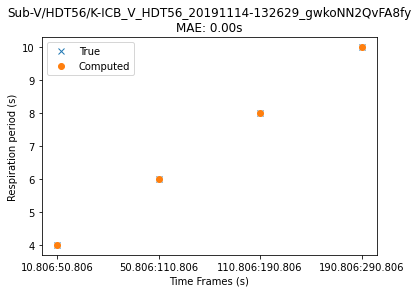

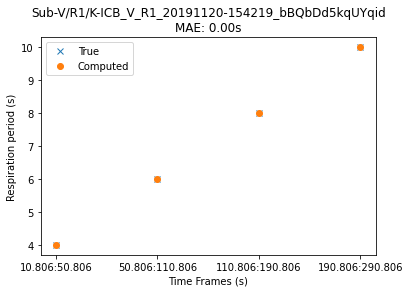

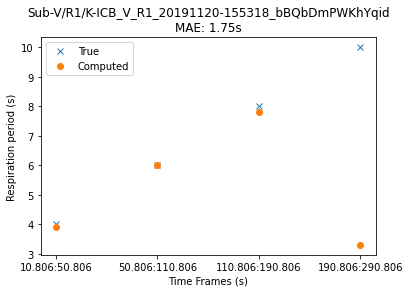

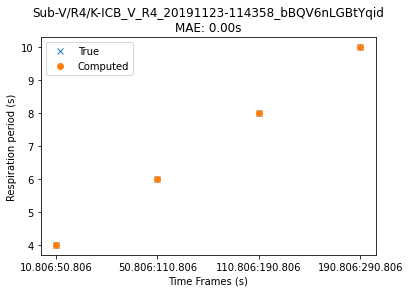

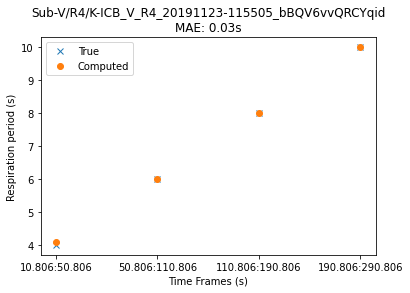

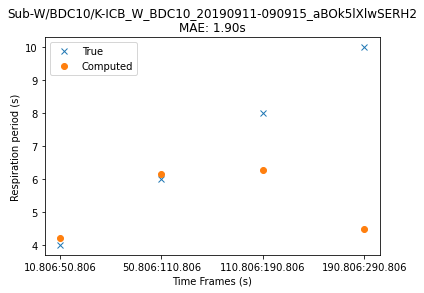

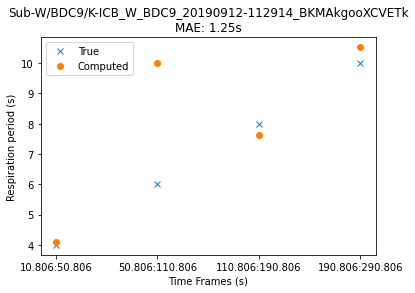

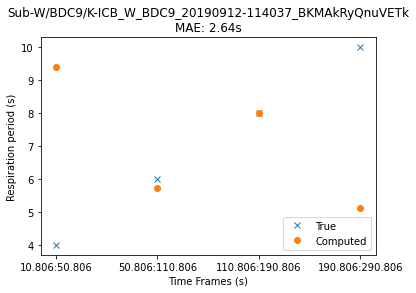

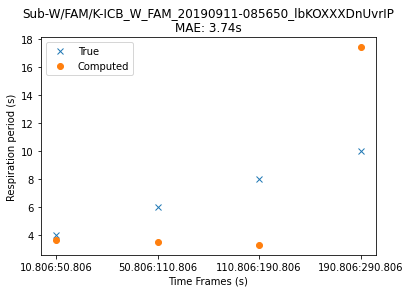

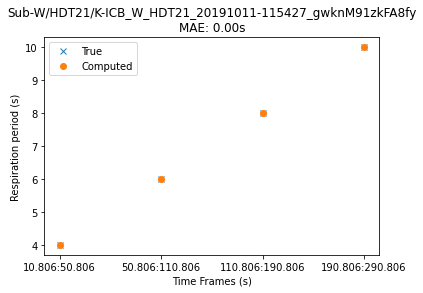

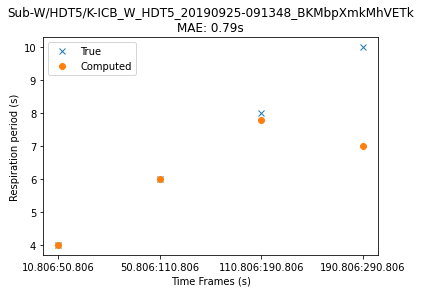

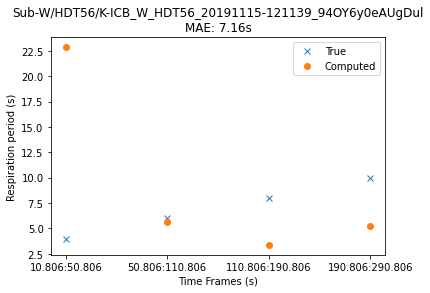

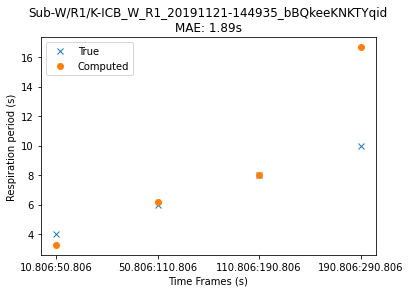

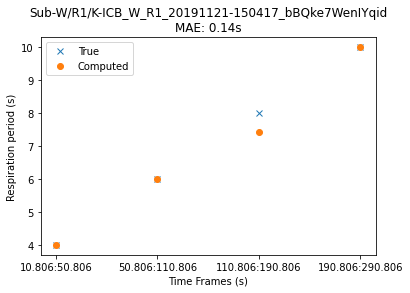

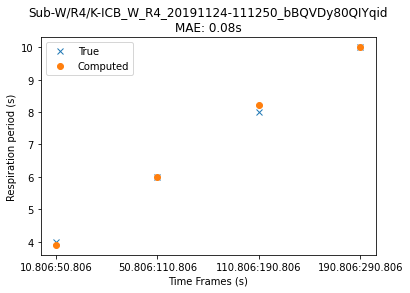

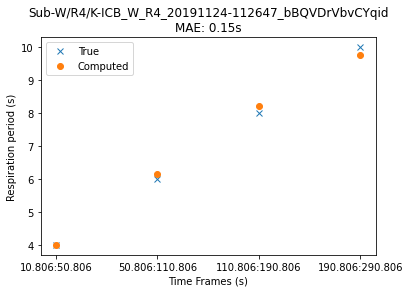

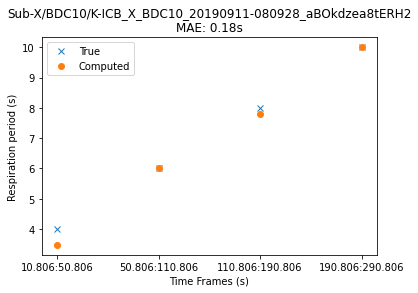

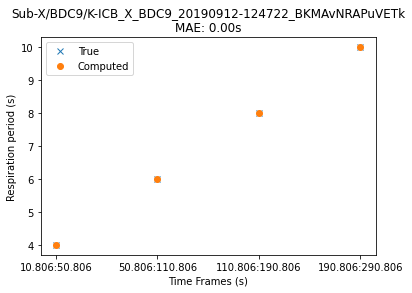

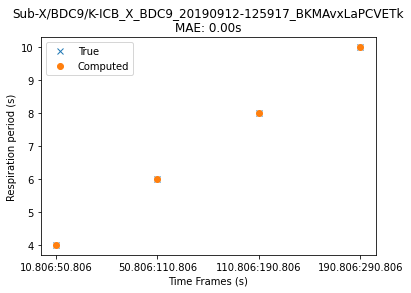

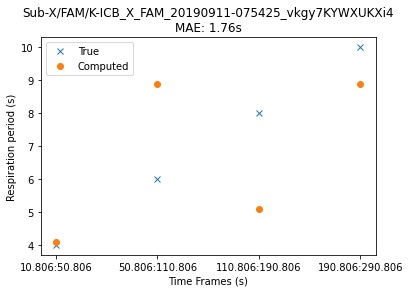

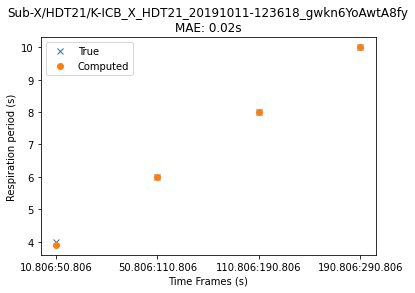

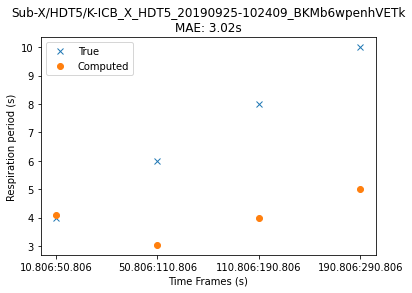

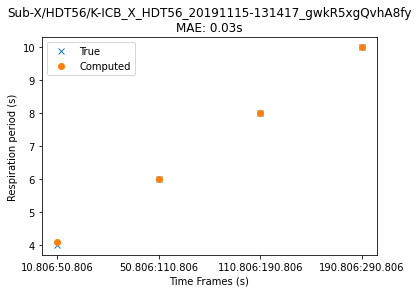

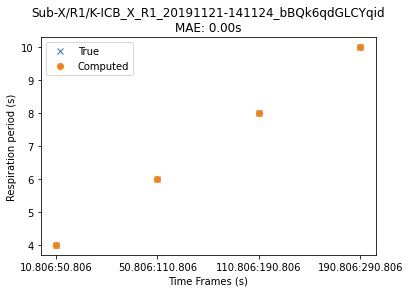

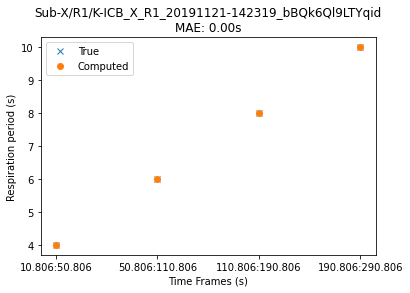

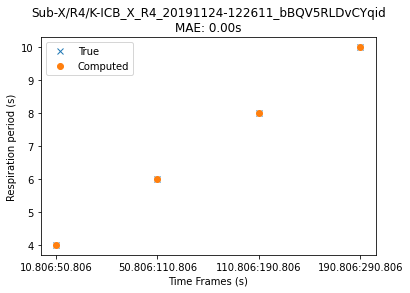

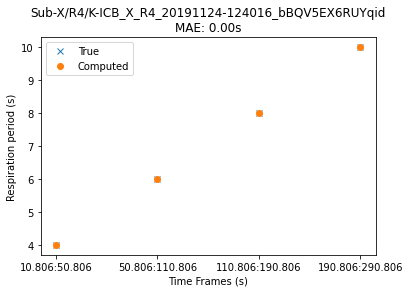

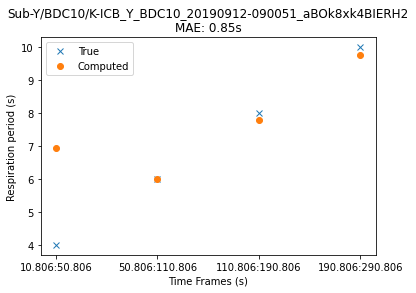

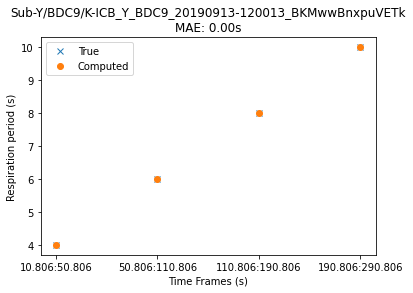

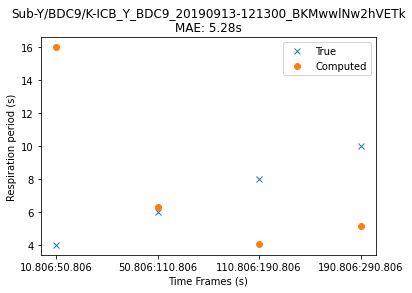

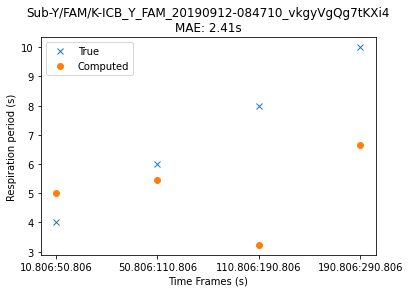

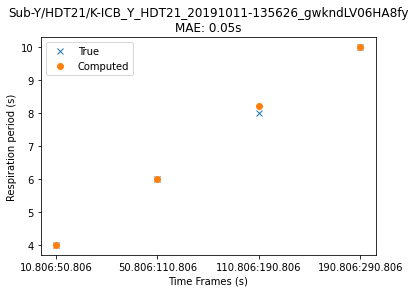

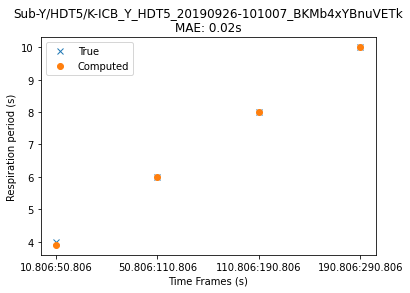

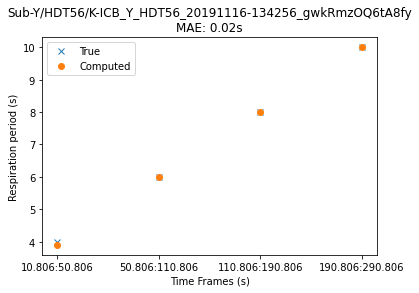

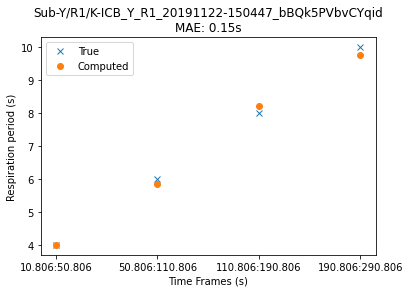

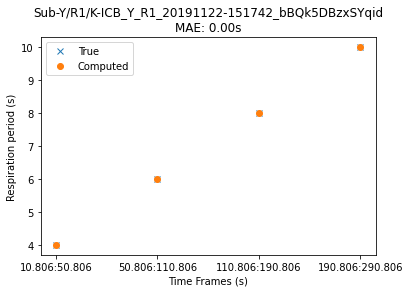

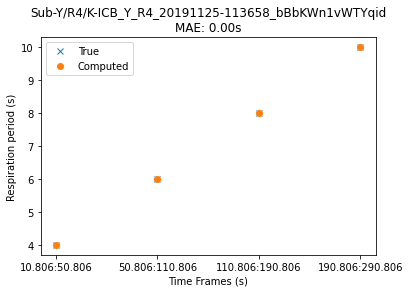

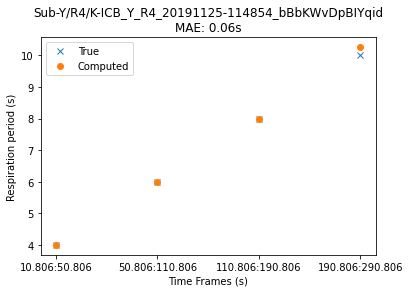

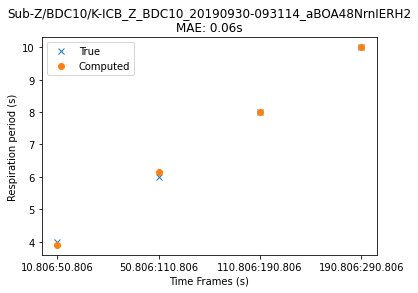

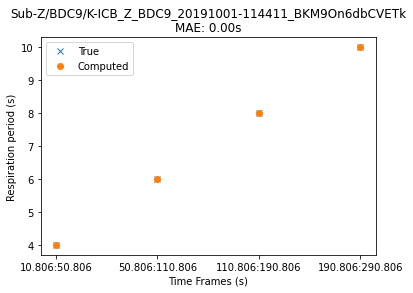

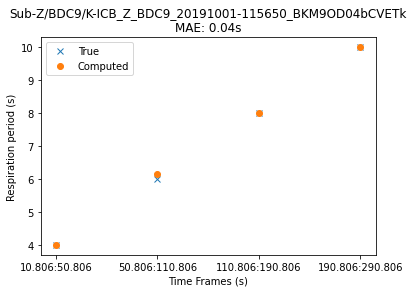

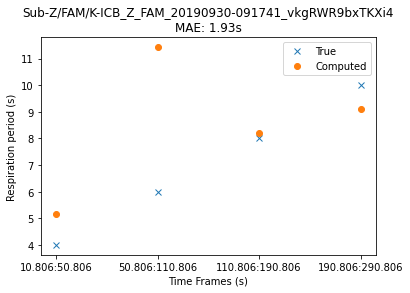

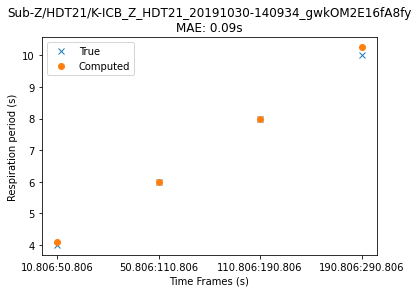

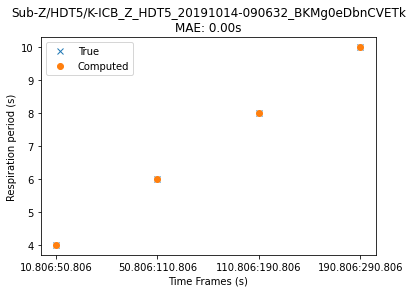

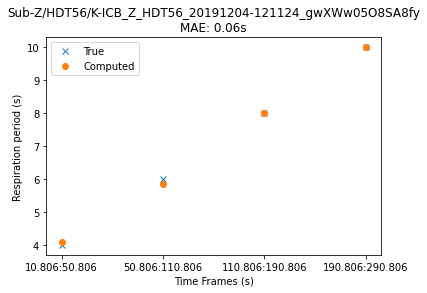

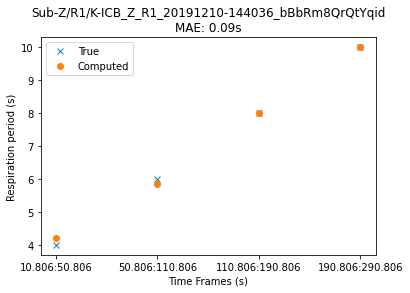

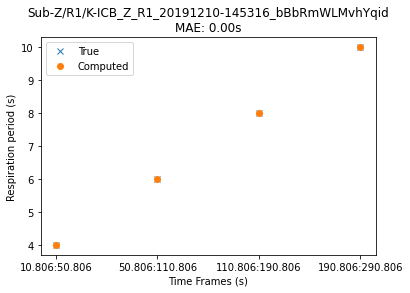

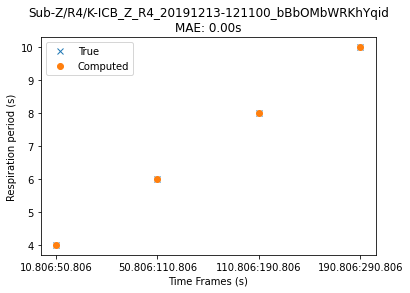

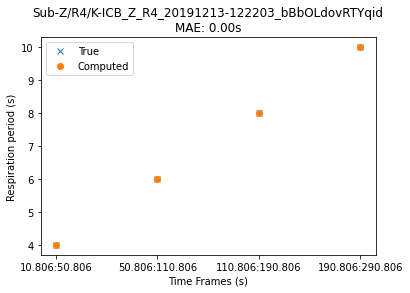

In [26]:
fcutoff = [0.1, 1]
distance_ms = 1000
prominence = 0.25
    
sec_path_all = []
err_all = []

for idx, i in enumerate(path_all):
    print(idx)
    record = read_record(i)
    scg = record.signals["scg"]
    s_rot = scg.vel.sel(motion="rot").values
    resp = fast_ica(s_rot, n_components=1)[:, 0]
    resp = filt_fir(resp, fs, fcutoff=fcutoff, filt_type="bandpass")
    resp = uniform_filter(resp, size=to_odd(int(window_smooth_ms * fs / 1000)))
    resp = nk.rsp.rsp_clean(resp)
    resp = detrend(resp)
    resp = scale_normalization(resp, rg=(-1, 1))
    resp = scale_standardization_robust(resp)
    resp = _correct_rsp_sign(resp, fs, distance_ms=distance_ms, prominence=prominence)
    resp_period_all_comp = []
    for k in time_frames:
        resp_cut = resp[int(k[0]*fs):int(k[1]*fs)]
        fpcntile, mpf, fmax, Ptotal, f, P = psd2(resp_cut-np.mean(resp_cut), fs=fs, nfft=8*np.ceil(len(resp_cut)/2), show=False)
        resp_period = 1/fmax
        resp_period_all_comp.append(resp_period)
    main_path = os.path.normpath(i)
    sec_path = main_path.split(os.sep)
    sec_path = sec_path[7]+'/'+sec_path[8]+'/'+sec_path[9]
    sec_path_all.append(sec_path)
    resp_period_all_true = [4, 6, 8, 10]
    err = mean_absolute_error(resp_period_all_true, resp_period_all_comp)
    err_all.append(err)
    plt.figure()
    x = np.array([0,1,2,3])
    my_xticks = ['10.806:50.806','50.806:110.806','110.806:190.806','190.806:290.806']
    plt.xticks(x, my_xticks)
    plt.plot(my_xticks, resp_period_all_true, 'x')
    plt.plot(my_xticks, resp_period_all_comp, 'o')
    plt.xlabel('Time Frames (s)')
    plt.ylabel("Respiration period (s)")
    plt.legend(['True', 'Computed'])
    plt.title(sec_path+ '\nMAE: ' +str(format(err, ".2f"))+ 's')

Text(0, 0.5, 'MAE (s)')

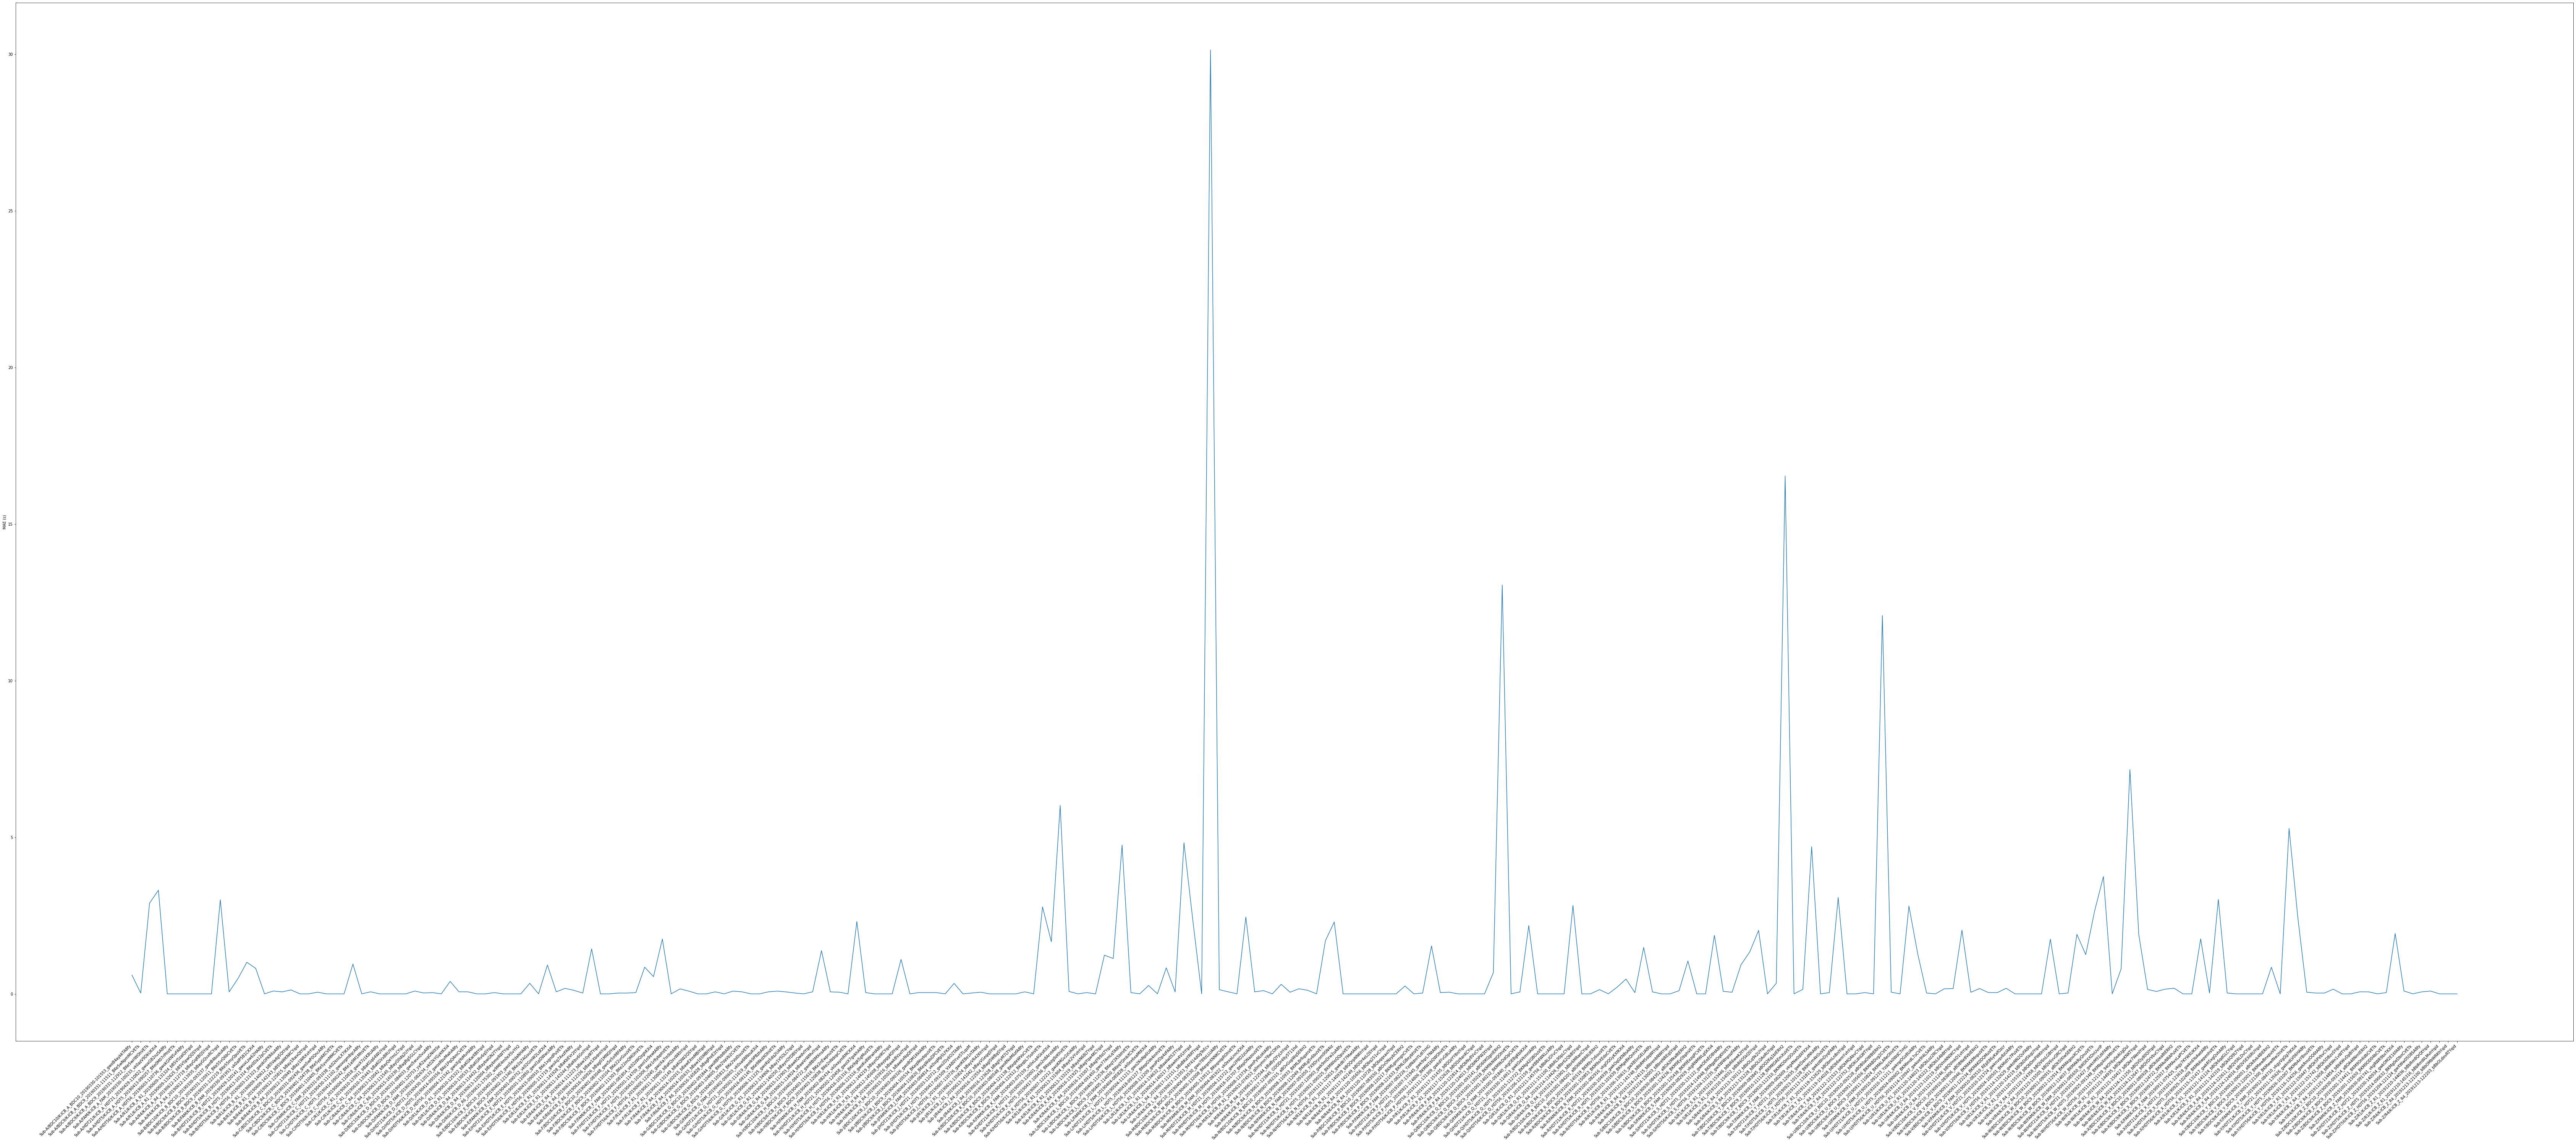

In [27]:
plt.figure(figsize=(120, 50))
x = np.array(range(len(sec_path_all)))
my_xticks = sec_path_all
plt.xticks(x, my_xticks, rotation=45, ha="right")
plt.plot(my_xticks, err_all)
plt.ylabel("MAE (s)")

In [28]:
import pickle

with open("/home/giuseppeditursi/Desktop/Respiration_from_SCG/2_Resp_Extraction/0_ICA/ICA_err_all", "wb") as fp:   #Pickling
    pickle.dump(err_all, fp)